# Ulepszony Model SIRD z Mechanizmami Redukcji Residuów i Prognozą Stochastyczną

## Wprowadzenie

Notebook ten implementuje model epidemiologiczny **SIRD** dla danych dotyczących epidemii Covid-19 w Polsce. Głównym celem projektu jest:

1.  **Dopasowanie parametrów:** Wykorzystanie PSO z akceleracją GPU, próbkowaniem Latin Hypercube (LHS), adaptacyjną bezwładnością i strategią wysp.
2.  **Korekcja residuów:** Zastosowanie zaawansowanych technik do modelowania i prognozowania błędów (residuów) modelu SIRD, w tym:
    *   Modele Transformer (sieci neuronowe z mechanizmem uwagi).
    *   Ulepszone Łańcuchy Markowa (z pamięcią i cechami czasowymi).
    *   Model hybrydowy łączący obie powyższe techniki.
3.  **Analiza stochastyczna:** Generowanie wielu symulacji w celu uchwycenia niepewności:
    *   **Bootstrapping parametrów:** Estymacja rozkładu parametrów modelu.
    *   **Generowanie zróżnicowanych parametrów:** Użycie Kernel Density Estimation (KDE) do próbkowania z estymowanego rozkładu.
    *   **Generowanie symulacji stochastycznych:** Uruchamianie modelu z różnymi zestawami parametrów.
4.  **Adaptacyjne przedziały ufności:** Tworzenie bardziej realistycznych przedziałów ufności uwzględniających błędy dopasowania i zmienność procesu.
5.  **Wizualizacja:** Czytelne wykresy przedstawiające medianę prognozy wraz z przedziałami ufności.

**Cel:** Uzyskanie dokładniejszych prognoz rozwoju epidemii oraz lepsze oszacowanie niepewności tych prognoz.

## 1. Setup: Import biblitoek, definicja parametrów globalnych

### 1.1 Import bibliotek

In [1]:
import numba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from numba import cuda
import time
import os
import json
import scipy.stats as stats
from datetime import datetime
from scipy.ndimage import gaussian_filter1d
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


### 1.2 Parametry globalne

brak parametru substeps -> korzystamy z RK4, nie Eulera.

In [2]:
MAX_ITER = 150
NUM_PARTICLES = 10_000
DT = 0.5
POPULATION = 38.2e6
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 2. Ładowanie i przygotowanie danych

In [ ]:
def load_covid_data(csv_path="data/preprocessed_Poland.csv"):
    df = pd.read_csv(csv_path, parse_dates=["Last_Update"])
    df = df.sort_values("Last_Update")
    return df.reset_index(drop=True)

## 3. Definicje modelii, komponentow podstawowych

### 3.1 Symulacja RK4, funkcja Beta

In [4]:
def seasonal_beta_function(day, t1, t2, beta1, beta2, forecast_start_day=None,
                          start_date=None, forecast_days=0, seasonal_factor=0.15):
    if day < t1:
        beta_base = beta1
    elif day < t2:
        frac = (day - t1) / max(t2 - t1, 1e-8)
        beta_base = beta1 + frac * (beta2 - beta1)
    else:
        beta_base = beta2
    if forecast_start_day is not None and day >= forecast_start_day:
        days_in_fc = day - forecast_start_day
        decay = 0.98 ** (days_in_fc / 7)
        beta_base *= decay
    if start_date is not None:
        curr_date = start_date + pd.Timedelta(days=day)
        doy = curr_date.dayofyear
        season = seasonal_factor * np.cos((doy - 15) * 2 * np.pi / 365)
        beta_base *= (1.0 + season)
    return beta_base
def enhanced_simulate_sird_rk4(params, days, S0, I0, R0, D0, dt=DT, Npop=POPULATION,
                           forecast_start_day=None, forecast_feedback=True, start_date=None):
    beta1, beta2, t1, t2, gamma_base, mu_base = params["beta1"], params["beta2"], params["t1"], params["t2"], params["gamma"], params["mu"]
    S_arr, I_arr, R_arr, D_arr = (np.zeros(days) for _ in range(4))
    S, I, R, D = S0, I0, R0, D0
    corr_factor = 1.0
    delay = 5
    I_hist = np.zeros(delay)
    I_hist[0] = I0

    def sird_derivs(S_loc, I_loc, R_loc, D_loc, day_idx, substep_frac):
        curr_day = day_idx + substep_frac
        avg_I = np.mean(I_hist)
        gamma_eff = gamma_base * (1.0 + 0.1 * (avg_I / max(I_loc, 1e-6) - 1))
        mu_eff = mu_base * (1.0 + 0.05 * (avg_I / max(I_loc, 1e-6) - 1))
        gamma_eff = max(0.8 * gamma_base, min(1.2 * gamma_base, gamma_eff))
        mu_eff = max(0.8 * mu_base, min(1.2 * mu_base, mu_eff))
        beta_t = seasonal_beta_function(curr_day, t1, t2, beta1, beta2, forecast_start_day, start_date, seasonal_factor=0.25)
        if forecast_start_day is not None and curr_day >= forecast_start_day:
            beta_t *= corr_factor
        dS = -beta_t * (S_loc * I_loc / Npop)
        dI = beta_t * (S_loc * I_loc / Npop) - (gamma_eff + mu_eff) * I_loc
        dR = gamma_eff * I_loc
        dD = mu_eff * I_loc
        return dS, dI, dR, dD

    for day in range(days):
        S_arr[day] = S
        I_arr[day] = I
        R_arr[day] = R
        D_arr[day] = D
        I_hist = np.roll(I_hist, 1)
        I_hist[0] = I
        if forecast_feedback and forecast_start_day is not None and day >= forecast_start_day:
            days_in_fc = day - forecast_start_day
            if days_in_fc > 0 and days_in_fc % 2 == 0:
                growth = (I - I_arr[max(0, day-2)]) / max(I_arr[max(0, day-2)], 1)
                if growth > 0.03:
                    corr_factor *= 0.93
                elif growth < -0.03:
                    corr_factor = min(1.0, corr_factor * 1.03)

        k1_S, k1_I, k1_R, k1_D = sird_derivs(S, I, R, D, day, 0.0)
        k2_S, k2_I, k2_R, k2_D = sird_derivs(S + 0.5*dt*k1_S, I + 0.5*dt*k1_I, R + 0.5*dt*k1_R, D + 0.5*dt*k1_D, day, 0.5)
        k3_S, k3_I, k3_R, k3_D = sird_derivs(S + 0.5*dt*k2_S, I + 0.5*dt*k2_I, R + 0.5*dt*k2_R, D + 0.5*dt*k2_D, day, 0.5)
        k4_S, k4_I, k4_R, k4_D = sird_derivs(S + dt*k3_S, I + dt*k3_I, R + dt*k3_R, D + dt*k3_D, day, 1.0)
        S_new = S + (dt/6)*(k1_S + 2*k2_S + 2*k3_S + k4_S)
        I_new = I + (dt/6)*(k1_I + 2*k2_I + 2*k3_I + k4_I)
        R_new = R + (dt/6)*(k1_R + 2*k2_R + 2*k3_R + k4_R)
        D_new = D + (dt/6)*(k1_D + 2*k2_D + 2*k3_D + k4_D)
        S_new = max(S_new, 0)
        I_new = max(I_new, 0)
        R_new = max(R_new, 0)
        D_new = max(D_new, 0)
        total = S_new + I_new + R_new + D_new
        if abs(total - Npop) > 1e-6:
            scale = Npop / (total + 1e-9)
            S_new *= scale
            I_new *= scale
            R_new *= scale
            D_new *= scale
        S, I, R, D = S_new, I_new, R_new, D_new
    return S_arr, I_arr, R_arr, D_arr

### 3.2 Optymalizacja  PSO z akceleracją GPU

#### 3.2.1 Kernel GPU dla obliczeń SIRD i kosztu

In [ ]:
@cuda.jit
def sird_rk4_gpu(beta1_arr, beta2_arr, t1_arr, t2_arr, gamma_arr, mu_arr, cost_arr, dt, Npop, days, I_emp, R_emp, D_emp, S0, I0, R0, D0, use_norm, i_min, i_rng, r_min, r_rng, d_min, d_rng, d_weight=5.0, i_weight=2.0):
    pid = cuda.grid(1)
    if pid < beta1_arr.size:
        beta1 = beta1_arr[pid]
        beta2 = beta2_arr[pid]
        t1 = t1_arr[pid]
        t2 = t2_arr[pid]
        gamma_ = gamma_arr[pid]
        mu_ = mu_arr[pid]
        S = S0
        I = I0
        R = R0
        D = D0
        MAX_DAYS_GPU = 1500
        if days > MAX_DAYS_GPU:
            cost_arr[pid] = 1e30
            return
        I_sim = cuda.local.array(MAX_DAYS_GPU, dtype=numba.float32)
        R_sim = cuda.local.array(MAX_DAYS_GPU, dtype=numba.float32)
        D_sim = cuda.local.array(MAX_DAYS_GPU, dtype=numba.float32)

        def sird_derivs_kernel(S_loc, I_loc, day_idx, substep_frac):
            curr = day_idx + substep_frac
            beta_t = beta1
            if curr < t1:
                beta_t = beta1
            elif curr < t2:
                beta_t = beta1 + (curr - t1) / (t2 - t1 + 1e-8) * (beta2 - beta1)
            else:
                beta_t = beta2
            dS = -beta_t * S_loc * I_loc / Npop
            dI = beta_t * S_loc * I_loc / Npop - (gamma_ + mu_) * I_loc
            dR = gamma_ * I_loc
            dD = mu_ * I_loc
            return dS, dI, dR, dD

        for day in range(days):
            k1S, k1I, k1R, k1D = sird_derivs_kernel(S, I, day, 0.0)
            k2S, k2I, k2R, k2D = sird_derivs_kernel(S + 0.5*dt*k1S, I + 0.5*dt*k1I, day, 0.5)
            k3S, k3I, k3R, k3D = sird_derivs_kernel(S + 0.5*dt*k2S, I + 0.5*dt*k2I, day, 0.5)
            k4S, k4I, k4R, k4D = sird_derivs_kernel(S + dt*k3S, I + dt*k3I, day, 1.0)
            Sn = S + (dt/6)*(k1S+2*k2S+2*k3S+k4S)
            In = I + (dt/6)*(k1I+2*k2I+2*k3I+k4I)
            Rn = R + (dt/6)*(k1R+2*k2R+2*k3R+k4R)
            Dn = D + (dt/6)*(k1D+2*k2D+2*k3D+k4D)
            Sn = max(Sn, 0)
            In = max(In, 0)
            Rn = max(Rn, 0)
            Dn = max(Dn, 0)
            tot = Sn + In + Rn + Dn
            if abs(tot - Npop) > 1e-6:
                scale = Npop / (tot + 1e-9)
                Sn *= scale
                In *= scale
                Rn *= scale
                Dn *= scale
            I_sim[day] = In
            R_sim[day] = Rn
            D_sim[day] = Dn
            S = Sn
            I = In
            R = Rn
            D = Dn

        i_err = 0.0
        r_err = 0.0
        d_err = 0.0
        for day in range(days):
            di = 0.0
            dr = 0.0
            dd = 0.0
            if use_norm == 1:
                if i_rng > 1e-12: di = ((I_sim[day] - i_min)/i_rng) - ((I_emp[day] - i_min)/i_rng)
                if r_rng > 1e-12: dr = ((R_sim[day] - r_min)/r_rng) - ((R_emp[day] - r_min)/r_rng)
                if d_rng > 1e-12: dd = ((D_sim[day] - d_min)/d_rng) - ((D_emp[day] - d_min)/d_rng)
            else:
                di = I_sim[day] - I_emp[day]
                dr = R_sim[day] - R_emp[day]
                dd = D_sim[day] - D_emp[day]
            i_err += abs(di)
            r_err += abs(dr)
            d_err += abs(dd)

        tot_err = i_err + r_err + d_err
        ad_i_w = i_weight
        ad_r_w = 1.0
        ad_d_w = d_weight
        if tot_err > 1e-10:
            ad_i_w = i_weight * (1.0 + i_err / tot_err)
            ad_r_w = 1.0 * (1.0 + r_err / tot_err)
            ad_d_w = d_weight * (1.0 + d_err / tot_err)

        sse = 0.0
        for day in range(days):
            di = 0.0
            dr = 0.0
            dd = 0.0
            if use_norm == 1:
                if i_rng > 1e-12: di = ((I_sim[day] - i_min)/i_rng) - ((I_emp[day] - i_min)/i_rng)
                if r_rng > 1e-12: dr = ((R_sim[day] - r_min)/r_rng) - ((R_emp[day] - r_min)/r_rng)
                if d_rng > 1e-12: dd = ((D_sim[day] - d_min)/d_rng) - ((D_emp[day] - d_min)/d_rng)
            else:
                di = I_sim[day] - I_emp[day]
                dr = R_sim[day] - R_emp[day]
                dd = D_sim[day] - D_emp[day]
            sse += di*di*ad_i_w + dr*dr*ad_r_w + dd*dd*ad_d_w
        cost_arr[pid] = sse

#### 3.2.2 Funkcje pomocnicze PSO (LHS, Inicjalizacja)

In [6]:
def latin_hypercube_sampling(n_samples, bounds, correlation_reduction=True):
    params = list(bounds.keys())
    n_params = len(params)
    lower_bounds = [bounds[p][0] for p in params]
    upper_bounds = [bounds[p][1] for p in params]
    if correlation_reduction:
        sampler = qmc.LatinHypercube(d=n_params, optimization="random-cd", seed=42)
        samples = sampler.random(n=n_samples)
        for _ in range(5):
            candidate = qmc.LatinHypercube(d=n_params, optimization="random-cd", seed=np.random.randint(1000)).random(n=n_samples)
            if qmc.discrepancy(candidate) < qmc.discrepancy(samples):
                samples = candidate
    else:
        sampler = qmc.LatinHypercube(d=n_params, seed=42)
        samples = sampler.random(n=n_samples)
    scaled_samples = qmc.scale(samples, lower_bounds, upper_bounds)
    result = {param: scaled_samples[:, i] for i, param in enumerate(params)}
    return result

def initialize_pso_with_lhs(n_particles, bounds):
    return latin_hypercube_sampling(n_particles, bounds)

#### 3.2.3 Główna funkcja PSO

In [7]:
def improved_pso_sird_gpu(
    days, D_emp, I_emp=None, R_emp=None, S0=0.0, I0=0.0, R0=0.0, D0=0.0,
    dt=DT, Npop=POPULATION, n_particles=NUM_PARTICLES, max_iter=MAX_ITER,
    bounds_beta1=(0.01, 1.5), bounds_beta2=(0.01, 1.5), bounds_t1=(0.0, 15.0),
    bounds_t2=(10.0, 40.0), bounds_gamma=(0.01, 0.3), bounds_mu=(0.001, 0.05),
    use_norm=True, d_weight=5.0, i_weight=2.0, r_weight=1.0,
    use_lhs=True, adaptive_inertia=True, use_islands=True, num_islands=4
):
    print("Uruchamianie ulepszonego PSO-SIRD z:")
    print(f"- LHS: {'Tak' if use_lhs else 'Nie'}, Adaptacyjna bezwładność: {'Tak' if adaptive_inertia else 'Nie'}, Wyspy: {'Tak' if use_islands else 'Nie'}, Cząsteczki: {n_particles}")
    W_init, W_final = (0.9, 0.4) if adaptive_inertia else (0.5, 0.5)
    n_islands, island_size = (0, 0) 
    if use_islands:
        safe_num_islands = min(num_islands, n_particles // 100) if n_particles >= 100 else 1 
        n_islands = max(1, safe_num_islands) 
        island_size = n_particles // n_islands
        print(f"- Liczba wysp: {n_islands} (po {island_size} cząstek)")

    C1_pso, C2_pso = 1.5, 1.5
    param_bounds = {'beta1': bounds_beta1, 'beta2': bounds_beta2, 't1': bounds_t1, 't2': bounds_t2, 'gamma': bounds_gamma, 'mu': bounds_mu}
    I_emp = np.zeros(days, dtype=np.float32) if I_emp is None else I_emp.astype(np.float32)
    R_emp = np.zeros(days, dtype=np.float32) if R_emp is None else R_emp.astype(np.float32)
    D_emp = D_emp.astype(np.float32)

    if use_lhs:
        try:
            samples = initialize_pso_with_lhs(n_particles, param_bounds)
            beta1, beta2, t1, t2, gamma, mu = samples['beta1'], samples['beta2'], samples['t1'], samples['t2'], samples['gamma'], samples['mu']
            t2 = np.maximum(t2, t1 + 1.0)
        except Exception as e:
            print(f"Błąd LHS: {e}. Używam standardowej inicjalizacji.")
            use_lhs = False
    if not use_lhs:
        beta1 = np.random.uniform(bounds_beta1[0], bounds_beta1[1], n_particles)
        beta2 = np.random.uniform(bounds_beta2[0], bounds_beta2[1], n_particles)
        t1 = np.random.uniform(bounds_t1[0], bounds_t1[1], n_particles)
        t2 = np.random.uniform(bounds_t2[0], bounds_t2[1], n_particles)
        gamma = np.random.uniform(bounds_gamma[0], bounds_gamma[1], n_particles)
        mu = np.random.uniform(bounds_mu[0], bounds_mu[1], n_particles)
        t2 = np.maximum(t2, t1 + 5.0)

    v_beta1, v_beta2, v_t1, v_t2, v_gamma, v_mu = (np.zeros(n_particles, dtype=np.float32) for _ in range(6))
    pbest_beta1, pbest_beta2, pbest_t1, pbest_t2, pbest_gamma, pbest_mu = beta1.copy(), beta2.copy(), t1.copy(), t2.copy(), gamma.copy(), mu.copy()
    pbest_cost = np.full(n_particles, 1e30, dtype=np.float32)
    gbest_cost = 1e30
    gbest_params = {"beta1": 0.0, "beta2": 0.0, "t1": 0.0, "t2": 0.0, "gamma": 0.0, "mu": 0.0}

    if use_norm:
        i_min, i_max = np.min(I_emp), np.max(I_emp)
        r_min, r_max = np.min(R_emp), np.max(R_emp)
        d_min, d_max = np.min(D_emp), np.max(D_emp)
        i_rng = max(i_max - i_min, 1e-6)
        r_rng = max(r_max - r_min, 1e-6)
        d_rng = max(d_max - d_min, 1e-6)
    else:
        i_min, i_rng, r_min, r_rng, d_min, d_rng = 0.0, 1.0, 0.0, 1.0, 0.0, 1.0

    D_emp_gpu = cuda.to_device(D_emp)
    I_emp_gpu = cuda.to_device(I_emp)
    R_emp_gpu = cuda.to_device(R_emp)
    beta1_gpu = cuda.to_device(beta1.astype(np.float32))
    beta2_gpu = cuda.to_device(beta2.astype(np.float32))
    t1_gpu = cuda.to_device(t1.astype(np.float32))
    t2_gpu = cuda.to_device(t2.astype(np.float32))
    gamma_gpu = cuda.to_device(gamma.astype(np.float32))
    mu_gpu = cuda.to_device(mu.astype(np.float32))
    cost_gpu = cuda.device_array(n_particles, dtype=np.float32)
    norm_data = np.array([i_min, i_rng, r_min, r_rng, d_min, d_rng], dtype=np.float32)
    norm_data_gpu = cuda.to_device(norm_data)
    use_norm_flag = 1 if use_norm else 0
    threadsperblock = 256
    blockspergrid = (n_particles + threadsperblock - 1) // threadsperblock

    if use_islands:
        island_indices = [np.arange(i * island_size, (i + 1) * island_size if i < n_islands - 1 else n_particles) for i in range(n_islands)]
        island_best_cost = np.full(n_islands, 1e30, dtype=np.float32)
        island_best_params = [{"beta1": 0.0, "beta2": 0.0, "t1": 0.0, "t2": 0.0, "gamma": 0.0, "mu": 0.0} for _ in range(n_islands)]

    history = []
    no_improvement_count = 0
    start_time = time.time()
    for iteration in range(max_iter):
        if iteration % 20 == 0 or iteration == max_iter - 1:
            elapsed = time.time() - start_time
            print(f"Iteracja {iteration}/{max_iter}: Najlepszy koszt = {gbest_cost:.8f}, czas: {elapsed:.2f}s")
        w = W_init - (W_init - W_final) * iteration / max_iter if adaptive_inertia else W_init
        sird_rk4_gpu[blockspergrid, threadsperblock](
            beta1_gpu, beta2_gpu, t1_gpu, t2_gpu, gamma_gpu, mu_gpu, cost_gpu,
            dt, Npop, days, I_emp_gpu, R_emp_gpu, D_emp_gpu,
            S0, I0, R0, D0, use_norm_flag,
            norm_data_gpu[0], norm_data_gpu[1], norm_data_gpu[2],
            norm_data_gpu[3], norm_data_gpu[4], norm_data_gpu[5],
            d_weight, i_weight
        )
        cuda.synchronize()
        cost_values = cost_gpu.copy_to_host()
        better = cost_values < pbest_cost
        pbest_cost[better] = cost_values[better]
        pbest_beta1[better] = beta1[better]
        pbest_beta2[better] = beta2[better]
        pbest_t1[better] = t1[better]
        pbest_t2[better] = t2[better]
        pbest_gamma[better] = gamma[better]
        pbest_mu[better] = mu[better]
        min_idx = np.argmin(cost_values)
        min_cost = cost_values[min_idx]
        if min_cost < gbest_cost:
            gbest_cost = min_cost
            gbest_params = {"beta1": beta1[min_idx], "beta2": beta2[min_idx], "t1": t1[min_idx],
                            "t2": t2[min_idx], "gamma": gamma[min_idx], "mu": mu[min_idx]}
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        history.append(gbest_cost)
        if use_islands:
            for i, indices in enumerate(island_indices):
                island_min_idx = indices[np.argmin(cost_values[indices])]
                island_min_cost = cost_values[island_min_idx]
                if island_min_cost < island_best_cost[i]:
                    island_best_cost[i] = island_min_cost
                    island_best_params[i] = {"beta1": beta1[island_min_idx], "beta2": beta2[island_min_idx],
                                             "t1": t1[island_min_idx], "t2": t2[island_min_idx],
                                             "gamma": gamma[island_min_idx], "mu": mu[island_min_idx]}
        if no_improvement_count > 30:
            print(f"Wczesne zatrzymanie po {iteration} iteracjach")
            break

        if use_islands:
            for i, indices in enumerate(island_indices):
                r1, r2, r3 = np.random.rand(len(indices)), np.random.rand(len(indices)), np.random.rand(len(indices))
                gw, lw = 0.7, 0.3
                v_beta1[indices] = w * v_beta1[indices] + C1_pso * r1 * (pbest_beta1[indices] - beta1[indices]) + C2_pso * gw * r2 * (gbest_params["beta1"] - beta1[indices]) + C2_pso * lw * r3 * (island_best_params[i]["beta1"] - beta1[indices])
                r1, r2, r3 = np.random.rand(len(indices)), np.random.rand(len(indices)), np.random.rand(len(indices))
                v_beta2[indices] = w * v_beta2[indices] + C1_pso * r1 * (pbest_beta2[indices] - beta2[indices]) + C2_pso * gw * r2 * (gbest_params["beta2"] - beta2[indices]) + C2_pso * lw * r3 * (island_best_params[i]["beta2"] - beta2[indices])
                r1, r2, r3 = np.random.rand(len(indices)), np.random.rand(len(indices)), np.random.rand(len(indices))
                v_t1[indices] = w * v_t1[indices] + C1_pso * r1 * (pbest_t1[indices] - t1[indices]) + C2_pso * gw * r2 * (gbest_params["t1"] - t1[indices]) + C2_pso * lw * r3 * (island_best_params[i]["t1"] - t1[indices])
                r1, r2, r3 = np.random.rand(len(indices)), np.random.rand(len(indices)), np.random.rand(len(indices))
                v_t2[indices] = w * v_t2[indices] + C1_pso * r1 * (pbest_t2[indices] - t2[indices]) + C2_pso * gw * r2 * (gbest_params["t2"] - t2[indices]) + C2_pso * lw * r3 * (island_best_params[i]["t2"] - t2[indices])
                r1, r2, r3 = np.random.rand(len(indices)), np.random.rand(len(indices)), np.random.rand(len(indices))
                v_gamma[indices] = w * v_gamma[indices] + C1_pso * r1 * (pbest_gamma[indices] - gamma[indices]) + C2_pso * gw * r2 * (gbest_params["gamma"] - gamma[indices]) + C2_pso * lw * r3 * (island_best_params[i]["gamma"] - gamma[indices])
                r1, r2, r3 = np.random.rand(len(indices)), np.random.rand(len(indices)), np.random.rand(len(indices))
                v_mu[indices] = w * v_mu[indices] + C1_pso * r1 * (pbest_mu[indices] - mu[indices]) + C2_pso * gw * r2 * (gbest_params["mu"] - mu[indices]) + C2_pso * lw * r3 * (island_best_params[i]["mu"] - mu[indices])
        else:
            r1, r2 = np.random.rand(n_particles), np.random.rand(n_particles)
            v_beta1 = w * v_beta1 + C1_pso * r1 * (pbest_beta1 - beta1) + C2_pso * r2 * (gbest_params["beta1"] - beta1)
            r1, r2 = np.random.rand(n_particles), np.random.rand(n_particles)
            v_beta2 = w * v_beta2 + C1_pso * r1 * (pbest_beta2 - beta2) + C2_pso * r2 * (gbest_params["beta2"] - beta2)
            r1, r2 = np.random.rand(n_particles), np.random.rand(n_particles)
            v_t1 = w * v_t1 + C1_pso * r1 * (pbest_t1 - t1) + C2_pso * r2 * (gbest_params["t1"] - t1)
            r1, r2 = np.random.rand(n_particles), np.random.rand(n_particles)
            v_t2 = w * v_t2 + C1_pso * r1 * (pbest_t2 - t2) + C2_pso * r2 * (gbest_params["t2"] - t2)
            r1, r2 = np.random.rand(n_particles), np.random.rand(n_particles)
            v_gamma = w * v_gamma + C1_pso * r1 * (pbest_gamma - gamma) + C2_pso * r2 * (gbest_params["gamma"] - gamma)
            r1, r2 = np.random.rand(n_particles), np.random.rand(n_particles)
            v_mu = w * v_mu + C1_pso * r1 * (pbest_mu - mu) + C2_pso * r2 * (gbest_params["mu"] - mu)

        beta1 += v_beta1
        beta2 += v_beta2
        t1 += v_t1
        t2 += v_t2
        gamma += v_gamma
        mu += v_mu

        beta1 = np.clip(beta1, bounds_beta1[0], bounds_beta1[1])
        beta2 = np.clip(beta2, bounds_beta2[0], bounds_beta2[1])
        t1 = np.clip(t1, bounds_t1[0], bounds_t1[1])
        t2 = np.clip(t2, bounds_t2[0], bounds_t2[1])
        t2 = np.maximum(t2, t1 + 1.0)
        gamma = np.clip(gamma, bounds_gamma[0], bounds_gamma[1])
        mu = np.clip(mu, bounds_mu[0], bounds_mu[1])

        beta1_gpu.copy_to_device(beta1.astype(np.float32))
        beta2_gpu.copy_to_device(beta2.astype(np.float32))
        t1_gpu.copy_to_device(t1.astype(np.float32))
        t2_gpu.copy_to_device(t2.astype(np.float32))
        gamma_gpu.copy_to_device(gamma.astype(np.float32))
        mu_gpu.copy_to_device(mu.astype(np.float32))

        if no_improvement_count > 15 and iteration < max_iter * 0.7:
            print(f"Zastosowanie mechanizmu różnorodności w iteracji {iteration}")
            n_reinit = int(n_particles * 0.25)
            reinit_indices = np.random.choice(n_particles, n_reinit, replace=False)
            loc_idx = reinit_indices[:n_reinit//3]
            glob_idx = reinit_indices[n_reinit//3:2*n_reinit//3]
            cross_idx = reinit_indices[2*n_reinit//3:]
            if len(loc_idx) > 0:
                beta1[loc_idx] = np.random.normal(gbest_params["beta1"], abs(gbest_params["beta1"]) * 0.2, len(loc_idx))
                beta2[loc_idx] = np.random.normal(gbest_params["beta2"], abs(gbest_params["beta2"]) * 0.2, len(loc_idx))
                t1[loc_idx] = np.random.normal(gbest_params["t1"], max(1.0, abs(gbest_params["t1"]) * 0.2), len(loc_idx))
                t2[loc_idx] = np.random.normal(gbest_params["t2"], max(1.0, abs(gbest_params["t2"]) * 0.2), len(loc_idx))
                gamma[loc_idx] = np.random.normal(gbest_params["gamma"], abs(gbest_params["gamma"]) * 0.2, len(loc_idx))
                mu[loc_idx] = np.random.normal(gbest_params["mu"], abs(gbest_params["mu"]) * 0.2, len(loc_idx))
            if len(glob_idx) > 0:
                beta1[glob_idx] = np.random.uniform(bounds_beta1[0], bounds_beta1[1], len(glob_idx))
                beta2[glob_idx] = np.random.uniform(bounds_beta2[0], bounds_beta2[1], len(glob_idx))
                t1[glob_idx] = np.random.uniform(bounds_t1[0], bounds_t1[1], len(glob_idx))
                t2[glob_idx] = np.random.uniform(bounds_t2[0], bounds_t2[1], len(glob_idx))
                gamma[glob_idx] = np.random.uniform(bounds_gamma[0], bounds_gamma[1], len(glob_idx))
                mu[glob_idx] = np.random.uniform(bounds_mu[0], bounds_mu[1], len(glob_idx))
            if len(cross_idx) > 0:
                best_indices = np.argsort(pbest_cost)[:20]
                for idx in cross_idx:
                    p1, p2 = np.random.choice(best_indices, 2, replace=False)
                    alpha = np.random.uniform(0.3, 0.7)
                    mut = 0.1
                    beta1[idx] = (beta1[p1] * alpha + beta1[p2] * (1 - alpha)) * np.random.uniform(1-mut, 1+mut)
                    beta2[idx] = (beta2[p1] * alpha + beta2[p2] * (1 - alpha)) * np.random.uniform(1-mut, 1+mut)
                    t1[idx] = (t1[p1] * alpha + t1[p2] * (1 - alpha)) * np.random.uniform(1-mut, 1+mut)
                    t2[idx] = (t2[p1] * alpha + t2[p2] * (1 - alpha)) * np.random.uniform(1-mut, 1+mut)
                    gamma[idx] = (gamma[p1] * alpha + gamma[p2] * (1 - alpha)) * np.random.uniform(1-mut, 1+mut)
                    mu[idx] = (mu[p1] * alpha + mu[p2] * (1 - alpha)) * np.random.uniform(1-mut, 1+mut)
            beta1 = np.clip(beta1, bounds_beta1[0], bounds_beta1[1])
            beta2 = np.clip(beta2, bounds_beta2[0], bounds_beta2[1])
            t1 = np.clip(t1, bounds_t1[0], bounds_t1[1])
            t2 = np.clip(t2, bounds_t2[0], bounds_t2[1])
            t2 = np.maximum(t2, t1 + 1.0)
            gamma = np.clip(gamma, bounds_gamma[0], bounds_gamma[1])
            mu = np.clip(mu, bounds_mu[0], bounds_mu[1])
            v_beta1[reinit_indices] = 0
            v_beta2[reinit_indices] = 0
            v_t1[reinit_indices] = 0
            v_t2[reinit_indices] = 0
            v_gamma[reinit_indices] = 0
            v_mu[reinit_indices] = 0
            beta1_gpu.copy_to_device(beta1.astype(np.float32))
            beta2_gpu.copy_to_device(beta2.astype(np.float32))
            t1_gpu.copy_to_device(t1.astype(np.float32))
            t2_gpu.copy_to_device(t2.astype(np.float32))
            gamma_gpu.copy_to_device(gamma.astype(np.float32))
            mu_gpu.copy_to_device(mu.astype(np.float32))

    best_params_final = {k: float(v) for k, v in gbest_params.items()}
    del D_emp_gpu, I_emp_gpu, R_emp_gpu, beta1_gpu, beta2_gpu, t1_gpu, t2_gpu, gamma_gpu, mu_gpu, cost_gpu, norm_data_gpu
    print(f"PSO zakończone po {len(history)} iteracjach w {time.time() - start_time:.2f} s. Najlepszy koszt: {gbest_cost:.8f}. Parametry: {best_params_final}")
    return best_params_final, history


#### 3.2.4 Wielofazowe PSO

In [8]:
def multi_phase_pso(df, start_date, end_date, forecast_days=21, use_lhs=True,
                   adaptive_inertia=True, use_islands=True, population=POPULATION,
                   dt=DT, i_weight=2.0, d_weight=5.0, use_norm=True):
    dfw = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy()
    dfw.reset_index(drop=True, inplace=True)
    days_window = len(dfw)

    print(f"Wielofazowe PSO: Dopasowanie dla okresu {start_date.date()} do {end_date.date()} ({days_window} dni)")

    I_emp = dfw["Active"].values.astype(np.float32)
    R_emp = dfw["Recovered"].values.astype(np.float32)
    D_emp = dfw["Deaths"].values.astype(np.float32)

    row0 = dfw.iloc[0]
    S0 = population - (row0["Active"] + row0["Recovered"] + row0["Deaths"])
    I0 = row0["Active"]
    R0 = row0["Recovered"]
    D0 = row0["Deaths"]

    print("Faza 1: Szeroka eksploracja przestrzeni parametrów")
    wide_bounds_beta1 = (0.01, 1.5)
    wide_bounds_beta2 = (0.01, 1.5)
    wide_bounds_t1 = (0.0, 15.0)
    wide_bounds_t2 = (10.0, 40.0)
    wide_bounds_gamma = (0.01, 0.3)
    wide_bounds_mu = (0.001, 0.05)

    phase1_params, phase1_history = improved_pso_sird_gpu(
        days=days_window, D_emp=D_emp, I_emp=I_emp, R_emp=R_emp,
        S0=S0, I0=I0, R0=R0, D0=D0, dt=dt, Npop=population,
        n_particles=NUM_PARTICLES, max_iter=MAX_ITER,
        bounds_beta1=wide_bounds_beta1, bounds_beta2=wide_bounds_beta2,
        bounds_t1=wide_bounds_t1, bounds_t2=wide_bounds_t2,
        bounds_gamma=wide_bounds_gamma, bounds_mu=wide_bounds_mu,
        use_norm=use_norm, d_weight=d_weight, i_weight=i_weight,
        use_lhs=use_lhs, adaptive_inertia=adaptive_inertia, use_islands=use_islands
    )

    print("Faza 2: Dokładne dopasowanie w węższym obszarze")
    narrow_bounds_beta1 = (max(0.01, phase1_params["beta1"] * 0.7), min(1.5, phase1_params["beta1"] * 1.3))
    narrow_bounds_beta2 = (max(0.01, phase1_params["beta2"] * 0.7), min(1.5, phase1_params["beta2"] * 1.3))
    narrow_bounds_t1 = (max(0.0, phase1_params["t1"] - 2.5), min(15.0, phase1_params["t1"] + 2.5))
    narrow_bounds_t2 = (max(10.0, phase1_params["t2"] - 4.0), min(40.0, phase1_params["t2"] + 4.0))
    narrow_bounds_gamma = (max(0.01, phase1_params["gamma"] * 0.7), min(0.3, phase1_params["gamma"] * 1.3))
    narrow_bounds_mu = (max(0.001, phase1_params["mu"] * 0.7), min(0.05, phase1_params["mu"] * 1.3))

    if narrow_bounds_t2[0] <= narrow_bounds_t1[1]:
        narrow_bounds_t2 = (narrow_bounds_t1[1] + 1.0, narrow_bounds_t2[1])

    phase2_params, phase2_history = improved_pso_sird_gpu(
        days=days_window, D_emp=D_emp, I_emp=I_emp, R_emp=R_emp,
        S0=S0, I0=I0, R0=R0, D0=D0, dt=DT, Npop=population,
        n_particles=NUM_PARTICLES, max_iter=MAX_ITER,
        bounds_beta1=narrow_bounds_beta1, bounds_beta2=narrow_bounds_beta2,
        bounds_t1=narrow_bounds_t1, bounds_t2=narrow_bounds_t2,
        bounds_gamma=narrow_bounds_gamma, bounds_mu=narrow_bounds_mu,
        use_norm=True, d_weight=5.0, i_weight=2.0,
        use_lhs=False, adaptive_inertia=True, use_islands=True
    )

    phase1_cost = phase1_history[-1] if phase1_history else float('inf')
    phase2_cost = phase2_history[-1] if phase2_history else float('inf')

    if phase2_cost < phase1_cost:
        print("Wybrano parametry z Fazy 2 (dokładne dopasowanie).")
        return phase2_params, phase2_history
    else:
        print("Wybrano parametry z Fazy 1 (szeroka eksploracja).")
        return phase1_params, phase1_history

### 3.3 Modele Korekcji Residuów

### 3.3.1 Model Transformer

In [ ]:
class TransformerResidualModel:
    def __init__(self, seq_length=14, forecast_horizon=14, d_model=64, num_heads=4,
                 num_transformer_blocks=2, mlp_units=[128, 64], dropout=0.1,
                 learning_rate=0.001, batch_size=32, random_seed=42):
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        self.d_model = d_model
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.mlp_units = mlp_units
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.random_seed = random_seed
        self.input_dim = 3
        self.scalers = {'I': StandardScaler(), 'R': StandardScaler(), 'D': StandardScaler()}
        self.model = self._build_model()
        self.is_trained = False

    def _analyze_noise_level(self, residuals_dict):
        noise_levels = {}
        for comp in ['I', 'R', 'D']:
            values = residuals_dict[comp]
            noise_levels[comp] = np.std(values) / (np.mean(np.abs(values)) + 1e-6) if len(values) > 10 else 0.5
        mean_noise = np.mean(list(noise_levels.values()))
        self.dropout = min(0.3, self.dropout * 1.5) if mean_noise > 0.5 else max(0.05, self.dropout * 0.8)
        print(f"Poziomy szumu: {noise_levels}, dostosowany dropout: {self.dropout}")
        return noise_levels

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        x = layers.Conv1D(filters=self.d_model, kernel_size=1, activation='relu')(inputs)
        x = self._positional_encoding(x)
        for _ in range(self.num_transformer_blocks):
            x = self._transformer_block(x)
        x = layers.GlobalAveragePooling1D()(x)
        for dim in self.mlp_units:
            x = layers.Dense(dim, activation='relu')(x)
            x = layers.Dropout(self.dropout)(x)
        outputs = layers.Dense(self.forecast_horizon * 3)(x)
        outputs = layers.Reshape((self.forecast_horizon, 3))(outputs)
        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate), loss=MeanSquaredError())
        return model

    def _positional_encoding(self, x):
        positions = np.arange(self.seq_length)[:, np.newaxis]
        indices = np.arange(self.d_model)[np.newaxis, :]
        angles = positions * (1 / np.power(10000, (2 * (indices // 2)) / self.d_model))
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        pos_encoding = angles[np.newaxis, ...]
        return x + tf.cast(pos_encoding, dtype=tf.float32)

    def _transformer_block(self, x):
        attn_output = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.d_model // self.num_heads)(x, x)
        attn_output = layers.Dropout(self.dropout)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn = layers.Dense(self.d_model * 4, activation='relu')(x)
        ffn = layers.Dense(self.d_model)(ffn)
        ffn_output = layers.Dropout(self.dropout)(ffn)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)
        return x

    def _prepare_data(self, residuals_dict):
        I_res, R_res, D_res = residuals_dict['I'], residuals_dict['R'], residuals_dict['D']
        I_scaled = self.scalers['I'].fit_transform(I_res.reshape(-1, 1)).flatten()
        R_scaled = self.scalers['R'].fit_transform(R_res.reshape(-1, 1)).flatten()
        D_scaled = self.scalers['D'].fit_transform(D_res.reshape(-1, 1)).flatten()
        X, y = [], []
        n_samples = len(I_scaled)
        for i in range(n_samples - self.seq_length - self.forecast_horizon + 1):
            X.append(np.column_stack([I_scaled[i:i+self.seq_length], R_scaled[i:i+self.seq_length], D_scaled[i:i+self.seq_length]]))
            y.append(np.column_stack([I_scaled[i+self.seq_length:i+self.seq_length+self.forecast_horizon],
                                      R_scaled[i+self.seq_length:i+self.seq_length+self.forecast_horizon],
                                      D_scaled[i+self.seq_length:i+self.seq_length+self.forecast_horizon]]))
        if X and y:
            return np.array(X).reshape(-1, self.seq_length, 3), np.array(y).reshape(-1, self.forecast_horizon, 3)
        else:
            print("Za mało danych do utworzenia sekwencji!")
            return None, None

    def fit(self, residuals_dict, validation_split=0.2, epochs=100, verbose=1):
        print("Przygotowywanie danych do treningu modelu transformatora...")
        _ = self._analyze_noise_level(residuals_dict)
        X, y = self._prepare_data(residuals_dict)
        if X is None or y is None or len(X) < 10:
            print("Za mało danych do wytrenowania modelu transformatora!")
            self.is_trained = False
            return None
        print(f"Dane treningowe: {X.shape}, Etykiety: {y.shape}")
        callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)]
        print("Rozpoczęcie trenowania modelu transformatora...")
        history = self.model.fit(X, y, validation_split=validation_split, epochs=epochs,
                                 batch_size=self.batch_size, callbacks=callbacks, verbose=verbose)
        self.is_trained = True
        print("Zakończono trenowanie modelu transformatora.")
        return history

    def generate(self, residuals_dict, n_steps, last_observations=None):
        if not self.is_trained:
            print("Model nie został wytrenowany! Nie można generować prognoz.")
            print("Używam zapasowego generatora residuów.")
            return self._fallback_generator(residuals_dict, n_steps)
        I_res, R_res, D_res = residuals_dict['I'], residuals_dict['R'], residuals_dict['D']
        if last_observations is not None and len(last_observations) >= self.seq_length * 3:
            seq_data = np.array(last_observations[-self.seq_length*3:]).reshape(self.seq_length, 3)
        else:
            seq_data = np.column_stack([I_res[-self.seq_length:], R_res[-self.seq_length:], D_res[-self.seq_length:]])
        seq_norm = np.zeros_like(seq_data)
        seq_norm[:, 0] = self.scalers['I'].transform(seq_data[:, 0].reshape(-1, 1)).flatten()
        seq_norm[:, 1] = self.scalers['R'].transform(seq_data[:, 1].reshape(-1, 1)).flatten()
        seq_norm[:, 2] = self.scalers['D'].transform(seq_data[:, 2].reshape(-1, 1)).flatten()
        gen_res = []
        rem_steps = n_steps
        curr_input = seq_norm.reshape(1, self.seq_length, 3)
        while rem_steps > 0:
            steps_pred = min(rem_steps, self.forecast_horizon)
            pred_seq = self.model.predict(curr_input, verbose=0)[0, :steps_pred, :]
            for step in range(steps_pred):
                i = self.scalers['I'].inverse_transform(pred_seq[step, 0].reshape(-1, 1))[0, 0]
                r = self.scalers['R'].inverse_transform(pred_seq[step, 1].reshape(-1, 1))[0, 0]
                d = self.scalers['D'].inverse_transform(pred_seq[step, 2].reshape(-1, 1))[0, 0]
                gen_res.append([i, r, d])
            if steps_pred < self.seq_length:
                curr_input = np.concatenate([curr_input[0, steps_pred:, :], pred_seq]).reshape(1, self.seq_length, 3)
            else:
                curr_input = pred_seq[-self.seq_length:, :].reshape(1, self.seq_length, 3)
            rem_steps -= steps_pred
        gen_res = np.array(gen_res)
        return {'I': gen_res[:, 0], 'R': gen_res[:, 1], 'D': gen_res[:, 2]}

    def _fallback_generator(self, residuals_dict, n_steps):
        print("Używam zapasowego generatora residuów - AR(1) z szumem.")
        I_res, R_res, D_res = residuals_dict['I'], residuals_dict['R'], residuals_dict['D']
        I_m, I_s = np.mean(I_res), np.std(I_res)
        R_m, R_s = np.mean(R_res), np.std(R_res)
        D_m, D_s = np.mean(D_res), np.std(D_res)
        I_new = np.random.normal(I_m, I_s, n_steps)
        R_new = np.random.normal(R_m, R_s, n_steps)
        D_new = np.random.normal(D_m, D_s, n_steps)
        for i in range(1, n_steps):
            I_new[i] = 0.7 * I_new[i-1] + 0.3 * np.random.normal(I_m, I_s)
            R_new[i] = 0.8 * R_new[i-1] + 0.2 * np.random.normal(R_m, R_s)
            D_new[i] = 0.9 * D_new[i-1] + 0.1 * np.random.normal(D_m, D_s)
        return {'I': I_new, 'R': R_new, 'D': D_new}

    def plot_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        if 'lr' in history.history:
            plt.subplot(1, 2, 2)
            plt.plot(history.history['lr'])
            plt.title('Learning Rate')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

### 3.3.1 Ulepszony Model Łańcuchów Markowa

In [10]:
class EnhancedMarkovChainResiduals:
    def __init__(self, n_states=7, memory_length=5, random_state=42):
        self.n_states = n_states
        self.memory_length = memory_length
        self.random_state = random_state
        self.kmeans = KMeans(n_clusters=n_states, random_state=random_state, n_init=10)
        self.transition_matrix = None
        self.state_distributions = None
        self.initial_distribution = None
        self.use_pca = False
        self.pca = None
        self.memory_models = []
        self.use_memory_models = False

    def fit(self, residuals_dict):
        print("Trenowanie modelu Markowa na residuach...")
        I_res, R_res, D_res = residuals_dict['I'], residuals_dict['R'], residuals_dict['D']
        if len(I_res) < self.memory_length + 5:
            print(f"Za malo danych ({len(I_res)} dla pamięci = {self.memory_length}). Redukuje pamięć.")
            self.memory_length = max(1, len(I_res) // 3)
        data, temporal_features = [], []
        for i in range(self.memory_length, len(I_res)):
            curr = [I_res[i], R_res[i], D_res[i]]
            for lag in range(1, min(self.memory_length + 1, 4)):
                curr.extend([I_res[i] - I_res[i-lag], R_res[i] - R_res[i-lag], D_res[i] - D_res[i-lag]])
            mem = []
            for j in range(1, self.memory_length + 1):
                mem.extend([I_res[i-j], R_res[i-j], D_res[i-j]])
            data.append(curr)
            temporal_features.append(mem)

        if len(data) < 10:
            data = np.column_stack([I_res, R_res, D_res])
            states = self.kmeans.fit_predict(data)
            temporal_features = []
            self.use_pca = False
        else:
            data = np.array(data)
            temporal_features = np.array(temporal_features) if temporal_features else np.array([])
            if data.shape[1] > 10:
                try:
                    self.pca = PCA(n_components=min(10, data.shape[1]), random_state=self.random_state)
                    data_reduced = self.pca.fit_transform(data)
                    print(f"Zredukowano wymiarowosc z {data.shape[1]} do {data_reduced.shape[1]} za pomocą PCA.")
                    states = self.kmeans.fit_predict(data_reduced)
                    self.use_pca = True
                except Exception as e:
                    print(f"{e}. Uzywane beda oryginalne zmienne.")
                    states = self.kmeans.fit_predict(data)
                    self.use_pca = False
            else:
                states = self.kmeans.fit_predict(data)
                self.use_pca = False

        self.transition_matrix = np.zeros((self.n_states, self.n_states))
        if len(states) > 1:
            for i in range(len(states) - 1):
                self.transition_matrix[states[i], states[i+1]] += 1
            row_sums = self.transition_matrix.sum(axis=1)
            for i in range(self.n_states):
                if row_sums[i] > 0:
                    self.transition_matrix[i, :] /= row_sums[i]
        else:
            self.transition_matrix = np.ones((self.n_states, self.n_states)) / self.n_states

        self.initial_distribution = np.zeros(self.n_states)
        for s in states:
            self.initial_distribution[s] += 1
        self.initial_distribution = self.initial_distribution / len(states) if len(states) > 0 else np.ones(self.n_states) / self.n_states

        self.state_distributions = []
        default_dim = data.shape[1] if data.ndim > 1 else 3
        for state in range(self.n_states):
            idx = np.where(states == state)[0]
            if len(idx) > 1:
                state_data = data[idx]
                mean = np.mean(state_data, axis=0)
                try:
                    cov = np.cov(state_data, rowvar=False)
                    if np.isscalar(cov) or cov.ndim == 0: cov = np.array([[max(cov, 1e-6)]])
                    elif cov.ndim == 1: cov = np.diag(np.maximum(cov, 1e-6))
                    else: cov = np.maximum(cov, 1e-6 * np.eye(cov.shape[0]))
                except Exception as e:
                    print(f"Covariance error state {state}: {e}")
                    var = np.var(state_data, axis=0)
                    cov = np.diag(np.maximum(var, 1e-6))
                self.state_distributions.append((mean, cov))
            elif len(idx) == 1:
                mean = data[idx[0]]
                var_scale = 0.01 * np.mean(np.abs(mean)) + 1e-6
                cov = np.eye(mean.shape[0]) * var_scale
                self.state_distributions.append((mean, cov))
            else:
                mean = np.zeros(default_dim)
                cov = np.eye(default_dim) * 0.01
                self.state_distributions.append((mean, cov))
                print(f"Warning: No samples for state {state}")

        self.use_memory_models = False
        if len(temporal_features) > 0 and len(states) > 5:
            try:
                self.memory_models = []
                valid_models = 0
                for state in range(self.n_states):
                    prev_idx = np.where(states[:-1] == state)[0]
                    if len(prev_idx) > 5:
                        X = temporal_features[prev_idx]
                        y = states[1:][prev_idx]
                        model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, C=0.8, random_state=self.random_state)
                        try:
                            model.fit(X, y)
                            self.memory_models.append(model)
                            valid_models += 1
                        except Exception as e:
                            print(f"Error fitting memory model state {state}: {e}")
                            self.memory_models.append(None)
                    else:
                        self.memory_models.append(None)
                print(f"Trained {valid_models}/{self.n_states} memory models")
                self.use_memory_models = valid_models > 0
            except Exception as e:
                print(f"Error setting up memory models: {e}")
                self.use_memory_models = False

    def generate(self, n_steps, last_state=None, last_observations=None):
        if self.initial_distribution is None:
             print("Model Markowa nie został wytrenowany. Zwracam zera.")
             zeros = np.zeros(n_steps)
             return {'I': zeros, 'R': zeros, 'D': zeros}

        current_state = np.random.choice(self.n_states, p=self.initial_distribution) if last_state is None else last_state
        gen_res = []
        mem_win = np.array(last_observations).flatten() if last_observations is not None and self.use_memory_models else None

        for _ in range(n_steps):
            use_mem = (mem_win is not None and self.use_memory_models and
                       current_state < len(self.memory_models) and self.memory_models[current_state] is not None)
            next_state = -1
            if use_mem:
                try:
                    expected_features = self.memory_models[current_state].n_features_in_
                    if mem_win.shape[0] == expected_features:
                        probs = self.memory_models[current_state].predict_proba(mem_win.reshape(1, -1))[0]
                        next_state = np.random.choice(self.n_states, p=probs)
                    else:
                         print(f"Ostrzeżenie: Niezgodność wymiarów pamięci ({mem_win.shape[0]} vs {expected_features}). Używam standardowej macierzy przejść.")
                         use_mem = False
                except Exception as e:
                    print(f"{e}")
                    use_mem = False
            if not use_mem or next_state == -1:
                if current_state >= self.transition_matrix.shape[0] or np.sum(self.transition_matrix[current_state]) < 1e-9:
                    next_state = np.random.choice(self.n_states)
                else:
                    probs = self.transition_matrix[current_state]
                    probs = probs / (np.sum(probs) + 1e-9)
                    next_state = np.random.choice(self.n_states, p=probs)

            next_state = min(next_state, self.n_states - 1)
            target_dim = 3
            if self.state_distributions and next_state < len(self.state_distributions):
                 mean, cov = self.state_distributions[next_state]
            else:
                 print(f"Ostrzeżenie: Brak dystrybucji dla stanu {next_state}. Używam zer.")
                 mean, cov = np.zeros(target_dim), np.eye(target_dim) * 1e-6

            if mean.shape[0] > target_dim: mean = mean[:target_dim]
            if cov.ndim == 2 and cov.shape[0] > target_dim: cov = cov[:target_dim, :target_dim]
            elif cov.ndim == 1 and cov.shape[0] > target_dim: cov = cov[:target_dim]
            if mean.shape[0] < target_dim: mean = np.pad(mean, (0, target_dim - mean.shape[0]))
            if cov.ndim == 2 and cov.shape[0] < target_dim: cov = np.pad(cov, ((0, target_dim - cov.shape[0]), (0, target_dim - cov.shape[0])))
            elif cov.ndim == 1 and cov.shape[0] < target_dim: cov = np.pad(cov, (0, target_dim - cov.shape[0]))
            if cov.ndim == 1: cov = np.diag(np.maximum(cov, 1e-6))
            elif np.isscalar(cov): cov = np.eye(target_dim) * max(cov, 1e-6)

            try:
                if cov.ndim == 2 and cov.shape[0] > 1 and not np.all(np.linalg.eigvals(cov) >= -1e-9):
                    cov = cov + np.eye(cov.shape[0]) * max(1e-6, 0.01 * np.trace(cov) / cov.shape[0])
            except Exception as e:
                print(f"{e}")
                cov = np.diag(np.diag(cov))

            try:
                residual = multivariate_normal.rvs(mean=mean, cov=cov, size=1, random_state=self.random_state).flatten()
                if residual.shape[0] < target_dim: residual = np.pad(residual, (0, target_dim - residual.shape[0]))
                elif residual.shape[0] > target_dim: residual = residual[:target_dim]
                gen_res.append(residual)
                if mem_win is not None:
                    new_obs = residual[:target_dim]
                    mem_win = np.concatenate([new_obs, mem_win[:-target_dim]])
            except Exception as e:
                print(f"Błąd generowania residuów: {e}")
                diag_cov = np.diag(cov) if cov.ndim == 2 else cov
                simple_residual = mean + np.random.normal(0, 1, size=mean.shape) * np.sqrt(np.maximum(diag_cov, 1e-6))
                if simple_residual.shape[0] < target_dim: simple_residual = np.pad(simple_residual, (0, target_dim - simple_residual.shape[0]))
                elif simple_residual.shape[0] > target_dim: simple_residual = simple_residual[:target_dim]
                gen_res.append(simple_residual)
                if mem_win is not None:
                    new_obs = simple_residual[:target_dim]
                    mem_win = np.concatenate([new_obs, mem_win[:-target_dim]])

            current_state = next_state

        gen_res = np.array(gen_res)
        if gen_res.ndim == 1: gen_res = gen_res.reshape(-1, 1)
        if gen_res.shape[1] < 3:
             padded = np.zeros((gen_res.shape[0], 3))
             padded[:, :gen_res.shape[1]] = gen_res
             gen_res = padded

        return {'I': gen_res[:, 0], 'R': gen_res[:, 1], 'D': gen_res[:, 2]}

### 3.4 Funkcje Pomocnicze (ekstrakcja residuów, korekcja trendu)

In [11]:
def extract_residuals(S_simulations, I_simulations, R_simulations, D_simulations,
                      df, start_date, end_date):
    df_period = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy()
    df_period.reset_index(drop=True, inplace=True)
    population = POPULATION
    S_emp = population - (df_period["Active"] + df_period["Recovered"] + df_period["Deaths"]).values
    I_emp = df_period["Active"].values
    R_emp = df_period["Recovered"].values
    D_emp = df_period["Deaths"].values
    S_array, I_array, R_array, D_array = map(np.array, [S_simulations, I_simulations, R_simulations, D_simulations])
    train_len = len(df_period)
    if I_array.shape[0] == 0 or I_array.shape[1] < train_len:
         print("Ostrzeżenie: Brak wystarczających danych symulacyjnych do ekstrakcji residuów.")
         zeros = np.zeros(train_len)
         return {'S': zeros, 'I': zeros, 'R': zeros, 'D': zeros}
    S_median = np.median(S_array[:, :train_len], axis=0)
    I_median = np.median(I_array[:, :train_len], axis=0)
    R_median = np.median(R_array[:, :train_len], axis=0)
    D_median = np.median(D_array[:, :train_len], axis=0)
    S_residuals = S_emp - S_median
    I_residuals = I_emp - I_median
    R_residuals = R_emp - R_median
    D_residuals = D_emp - D_median
    return {'S': S_residuals, 'I': I_residuals, 'R': R_residuals, 'D': D_residuals}

def apply_trend_correction(params, df, start_date, end_date, forecast_days):
    df_last = df[(df["Last_Update"] > end_date - pd.Timedelta(days=7)) & (df["Last_Update"] <= end_date)].copy()
    if len(df_last) >= 5:
        I_val = df_last["Active"].values
        R_val = df_last["Recovered"].values
        D_val = df_last["Deaths"].values
        I_ch = np.mean(np.diff(I_val)) / (np.mean(I_val) + 1e-6)
        R_ch = np.mean(np.diff(R_val)) / (np.mean(R_val) + 1e-6)
        D_ch = np.mean(np.diff(D_val)) / (np.mean(D_val) + 1e-6)
        corr_p = params.copy()
        if I_ch < -0.01:
            corr_p["beta2"] *= max(0.7, 1.0 + 2 * I_ch)
        if R_ch > 0.01:
            corr_p["gamma"] *= min(1.3, 1.0 + R_ch)
        if D_ch > 0.01:
            corr_p["mu"] *= min(1.2, 1.0 + D_ch)
        print(f"Trend korekcja: beta2 {params['beta2']:.4f}->{corr_p['beta2']:.4f}, gamma {params['gamma']:.4f}->{corr_p['gamma']:.4f}, mu {params['mu']:.4f}->{corr_p['mu']:.4f}")
        return corr_p
    return params

In [ ]:
def apply_transformer_markov_hybrid_correction(S_simulations, I_simulations, R_simulations, D_simulations,
                                     df, start_date, end_date, forecast_days,
                                     transformer_weight=0.6):
    print(f"Stosowanie hybrydowej korekcji residuów (transformer + Markov)...")
    residuals = extract_residuals(S_simulations, I_simulations, R_simulations, D_simulations, df, start_date, end_date)
    transformer_residuals = None
    try:
        min_seq_length = min(5, len(residuals['I']))
        print(f"Próba treningu transformatora z długością sekwencji {min_seq_length}...")
        transformer_model = TransformerResidualModel(seq_length=min_seq_length, forecast_horizon=forecast_days)
        transformer_history = transformer_model.fit(residuals, epochs=150, validation_split=0.2, verbose=0)
        if transformer_history is not None and transformer_model.is_trained:
            print("Transformator wytrenowany pomyślnie!")
            memory_window = []
            for i in range(min(transformer_model.seq_length, len(residuals['I']))):
                day = len(residuals['I']) - 1 - i
                memory_window.extend([residuals['I'][day], residuals['R'][day], residuals['D'][day]])
            transformer_residuals = transformer_model.generate(residuals, forecast_days, memory_window)
        else:
            print("Nie udało się wytrenować transformatora.")
            transformer_weight = 0.0
    except Exception as e:
        print(f"Błąd podczas trenowania/generowania transformatora: {e}")
        transformer_weight = 0.0

    print("Trenowanie modelu Markowa...")
    mem_len_markov = min(5, len(residuals['I'])-1 if len(residuals['I']) > 1 else 1)
    markov_model = EnhancedMarkovChainResiduals(n_states=9, memory_length=mem_len_markov)
    markov_model.fit(residuals)
    last_residuals = np.array([residuals['I'][-1], residuals['R'][-1], residuals['D'][-1]]).reshape(1, -1)
    memory_window_markov = []
    for i in range(mem_len_markov):
        day = len(residuals['I']) - 2 - i
        if day >= 0:
            memory_window_markov.extend([residuals['I'][day], residuals['R'][day], residuals['D'][day]])

    last_state = 0 
    if hasattr(markov_model, 'kmeans') and hasattr(markov_model.kmeans, 'cluster_centers_'):
        if hasattr(markov_model, 'use_pca') and markov_model.use_pca and hasattr(markov_model, 'pca'):
            expected_dim = markov_model.pca.n_features_in_
            current_dim = last_residuals.shape[1]
            padding_needed = expected_dim - current_dim
            if padding_needed < 0: padding_needed = 0
            last_features_padded = np.concatenate([last_residuals.flatten(), np.zeros(padding_needed)])
            if last_features_padded.shape[0] == expected_dim:
                 try:
                     last_features_pca = markov_model.pca.transform(last_features_padded.reshape(1, -1))
                     last_state = markov_model.kmeans.predict(last_features_pca)[0]
                 except Exception as e:
                     print(f"Błąd predykcji PCA w hybrydzie: {e}. Używam standardowej.")
                     last_state = markov_model.kmeans.predict(last_residuals)[0]
            else:
                 print(f"Ostrzeżenie: Niezgodność wymiarów PCA w hybrydzie ({last_features_padded.shape[0]} vs {expected_dim}). Używam standardowej.")
                 last_state = markov_model.kmeans.predict(last_residuals)[0]
        else:
            last_state = markov_model.kmeans.predict(last_residuals)[0]
    else:
         print("Ostrzeżenie: Model Markowa (kmeans) nie zainicjalizowany w hybrydzie.")

    markov_residuals = markov_model.generate(forecast_days, last_state, memory_window_markov)

    combined_residuals = {'I': np.zeros(forecast_days), 'R': np.zeros(forecast_days), 'D': np.zeros(forecast_days)}
    if transformer_residuals is not None:
        for key in combined_residuals.keys():
            combined_residuals[key] = transformer_weight * transformer_residuals[key] + (1 - transformer_weight) * markov_residuals[key]
        print(f"Połączono residua z transformatora (waga {transformer_weight:.2f}) i modelu Markowa (waga {1-transformer_weight:.2f}).")
    else:
        combined_residuals = markov_residuals
        print("Użyto tylko residuów z modelu Markowa.")

    S_corrected, I_corrected, R_corrected, D_corrected = [], [], [], []
    S_array, I_array, R_array, D_array = map(np.array, [S_simulations, I_simulations, R_simulations, D_simulations])
    train_days = (end_date - start_date).days + 1
    decay_factor = np.exp(-np.arange(forecast_days) / 14)

    for i in range(len(I_simulations)):
        noise_factor = 0.15
        i_std = np.std(combined_residuals['I'])
        r_std = np.std(combined_residuals['R'])
        d_std = np.std(combined_residuals['D'])
        i_noise = np.random.normal(0, noise_factor * i_std) if i_std > 1e-9 else 0
        r_noise = np.random.normal(0, noise_factor * r_std) if r_std > 1e-9 else 0
        d_noise = np.random.normal(0, noise_factor * d_std) if d_std > 1e-9 else 0

        if forecast_days > 0:
            scale_i = min(1.0, 0.7 + np.random.uniform(-0.2, 0.2))
            scale_r = min(1.0, 0.6 + np.random.uniform(-0.2, 0.2))
            scale_d = min(1.0, 0.65 + np.random.uniform(-0.2, 0.2))
            forecast_len = min(forecast_days, I_array.shape[1] - train_days)
            if forecast_len <= 0:
                 I_sim = I_array[i, :].copy()
                 R_sim = R_array[i, :].copy()
                 D_sim = D_array[i, :].copy()
            else:
                I_forecast = I_array[i, train_days:train_days+forecast_len].copy()
                R_forecast = R_array[i, train_days:train_days+forecast_len].copy()
                D_forecast = D_array[i, train_days:train_days+forecast_len].copy()
                actual_forecast_days = min(forecast_len, len(combined_residuals['I']), len(decay_factor))
                for day in range(actual_forecast_days):
                    I_forecast[day] += scale_i * (combined_residuals['I'][day] + i_noise) * decay_factor[day]
                    R_forecast[day] += scale_r * (combined_residuals['R'][day] + r_noise) * decay_factor[day]
                    D_forecast[day] += scale_d * (combined_residuals['D'][day] + d_noise) * decay_factor[day]
                I_forecast = np.maximum(I_forecast, 0)
                R_forecast = np.maximum(R_forecast, 0)
                D_forecast = np.maximum(D_forecast, 0)
                I_sim = np.concatenate([I_array[i, :train_days], I_forecast])
                R_sim = np.concatenate([R_array[i, :train_days], R_forecast])
                D_sim = np.concatenate([D_array[i, :train_days], D_forecast])
        else:
            I_sim = I_array[i, :].copy()
            R_sim = R_array[i, :].copy()
            D_sim = D_array[i, :].copy()
        I_corrected.append(I_sim)
        R_corrected.append(R_sim)
        D_corrected.append(D_sim)

    for i in range(len(S_simulations)):
        s_len = min(S_array.shape[1], len(I_corrected[i]))
        old_sum = I_array[i, :s_len] + R_array[i, :s_len] + D_array[i, :s_len]
        new_sum = I_corrected[i][:s_len] + R_corrected[i][:s_len] + D_corrected[i][:s_len]
        S_sim = S_array[i, :s_len] - (new_sum - old_sum)
        S_corrected.append(S_sim)

    print("Hybrydowa korekcja residuów zakończona.")
    return S_corrected, I_corrected, R_corrected, D_corrected

In [ ]:
def apply_transformer_residuals_correction(S_simulations, I_simulations, R_simulations, D_simulations,
                                         df, start_date, end_date, forecast_days):
    print("Stosowanie korekcji residuów z użyciem modelu transformatora...")
    residuals = extract_residuals(S_simulations, I_simulations, R_simulations, D_simulations, df, start_date, end_date)
    transformer_model = TransformerResidualModel(seq_length=min(14, len(residuals['I'])), forecast_horizon=forecast_days)
    history = transformer_model.fit(residuals, epochs=200, validation_split=0.2, verbose=0)

    if not transformer_model.is_trained:
         print("Model transformatora nie został wytrenowany. Pomijam korekcję.")
         return S_simulations, I_simulations, R_simulations, D_simulations

    memory_window = []
    for i in range(min(transformer_model.seq_length, len(residuals['I']))):
        day = len(residuals['I']) - 1 - i
        memory_window.extend([residuals['I'][day], residuals['R'][day], residuals['D'][day]])
    forecast_residuals = transformer_model.generate(residuals, forecast_days, memory_window)

    S_corrected, I_corrected, R_corrected, D_corrected = [], [], [], []
    S_array, I_array, R_array, D_array = map(np.array, [S_simulations, I_simulations, R_simulations, D_simulations])
    train_days = (end_date - start_date).days + 1
    decay_factor = np.exp(-np.arange(forecast_days) / 15)
    correction_scales = {'I': 0.7, 'R': 0.5, 'D': 0.6}

    for i in range(len(I_simulations)):
        noise_factor = 0.15
        i_std = np.std(forecast_residuals['I'])
        r_std = np.std(forecast_residuals['R'])
        d_std = np.std(forecast_residuals['D'])
        i_noise = np.random.normal(0, noise_factor * i_std) if i_std > 1e-9 else 0
        r_noise = np.random.normal(0, noise_factor * r_std) if r_std > 1e-9 else 0
        d_noise = np.random.normal(0, noise_factor * d_std) if d_std > 1e-9 else 0

        if forecast_days > 0:
            i_scale = correction_scales['I'] * (1.0 + np.random.uniform(-0.1, 0.1))
            r_scale = correction_scales['R'] * (1.0 + np.random.uniform(-0.1, 0.1))
            d_scale = correction_scales['D'] * (1.0 + np.random.uniform(-0.1, 0.1))
            forecast_len = min(forecast_days, I_array.shape[1] - train_days)
            if forecast_len <= 0:
                 I_sim = I_array[i, :].copy()
                 R_sim = R_array[i, :].copy()
                 D_sim = D_array[i, :].copy()
            else:
                I_forecast = I_array[i, train_days:train_days+forecast_len].copy()
                R_forecast = R_array[i, train_days:train_days+forecast_len].copy()
                D_forecast = D_array[i, train_days:train_days+forecast_len].copy()
                actual_forecast_days = min(forecast_len, len(forecast_residuals['I']), len(decay_factor))
                for day in range(actual_forecast_days):
                    I_forecast[day] += i_scale * (forecast_residuals['I'][day] + i_noise) * decay_factor[day]
                    R_forecast[day] += r_scale * (forecast_residuals['R'][day] + r_noise) * decay_factor[day]
                    D_forecast[day] += d_scale * (forecast_residuals['D'][day] + d_noise) * decay_factor[day]
                I_forecast = np.maximum(I_forecast, 0)
                R_forecast = np.maximum(R_forecast, 0)
                D_forecast = np.maximum(D_forecast, 0)
                I_sim = np.concatenate([I_array[i, :train_days], I_forecast])
                R_sim = np.concatenate([R_array[i, :train_days], R_forecast])
                D_sim = np.concatenate([D_array[i, :train_days], D_forecast])
        else:
            I_sim = I_array[i, :].copy()
            R_sim = R_array[i, :].copy()
            D_sim = D_array[i, :].copy()
        I_corrected.append(I_sim)
        R_corrected.append(R_sim)
        D_corrected.append(D_sim)

    for i in range(len(S_simulations)):
        s_len = min(S_array.shape[1], len(I_corrected[i]))
        old_sum = I_array[i, :s_len] + R_array[i, :s_len] + D_array[i, :s_len]
        new_sum = I_corrected[i][:s_len] + R_corrected[i][:s_len] + D_corrected[i][:s_len]
        S_sim = S_array[i, :s_len] - (new_sum - old_sum)
        S_corrected.append(S_sim)

    return S_corrected, I_corrected, R_corrected, D_corrected

In [ ]:
def apply_enhanced_markov_residuals_correction(S_simulations, I_simulations, R_simulations, D_simulations,
                                    df, start_date, end_date, forecast_days):
    print("Applying enhanced Markov chain residual correction...")
    residuals = extract_residuals(S_simulations, I_simulations, R_simulations, D_simulations, df, start_date, end_date)
    if not residuals or np.all(residuals['I'] == 0):
         print("Ostrzeżenie: Puste lub zerowe residua. Pomijam korekcję Markowa.")
         return S_simulations, I_simulations, R_simulations, D_simulations

    mem_len_markov = min(5, len(residuals['I'])-1 if len(residuals['I']) > 1 else 1)
    markov_model = EnhancedMarkovChainResiduals(n_states=9, memory_length=mem_len_markov)
    markov_model.fit(residuals)
    last_residuals = np.array([residuals['I'][-1], residuals['R'][-1], residuals['D'][-1]]).reshape(1, -1)
    memory_window_markov = []
    for i in range(mem_len_markov):
        day = len(residuals['I']) - 2 - i
        if day >= 0:
            memory_window_markov.extend([residuals['I'][day], residuals['R'][day], residuals['D'][day]])

    last_state = 0
    if hasattr(markov_model, 'kmeans') and hasattr(markov_model.kmeans, 'cluster_centers_'):
        if hasattr(markov_model, 'use_pca') and markov_model.use_pca and hasattr(markov_model, 'pca'):
            expected_dim = markov_model.pca.n_features_in_
            current_dim = last_residuals.shape[1]
            padding_needed = expected_dim - current_dim
            if padding_needed < 0: padding_needed = 0
            last_features_padded = np.concatenate([last_residuals.flatten(), np.zeros(padding_needed)])
            if last_features_padded.shape[0] == expected_dim:
                 try:
                     last_features_pca = markov_model.pca.transform(last_features_padded.reshape(1, -1))
                     last_state = markov_model.kmeans.predict(last_features_pca)[0]
                 except Exception as e:
                     print(f"Błąd predykcji PCA w Markowie: {e}. Używam standardowej.")
                     last_state = markov_model.kmeans.predict(last_residuals)[0]
            else:
                 print(f"Ostrzeżenie: Niezgodność wymiarów PCA w Markowie ({last_features_padded.shape[0]} vs {expected_dim}). Używam standardowej.")
                 last_state = markov_model.kmeans.predict(last_residuals)[0]
        else:
            last_state = markov_model.kmeans.predict(last_residuals)[0]
    else:
         print("Ostrzeżenie: Model Markowa (kmeans) nie zainicjalizowany.")

    forecast_residuals = markov_model.generate(forecast_days, last_state, memory_window_markov)
    S_corrected, I_corrected, R_corrected, D_corrected = [], [], [], []
    S_array, I_array, R_array, D_array = map(np.array, [S_simulations, I_simulations, R_simulations, D_simulations])
    train_days = (end_date - start_date).days + 1
    decay_factor = np.exp(-np.arange(forecast_days) / 14)

    for i in range(len(I_simulations)):
        noise_factor = 0.15
        i_std = np.std(forecast_residuals['I'])
        r_std = np.std(forecast_residuals['R'])
        d_std = np.std(forecast_residuals['D'])
        i_noise = np.random.normal(0, noise_factor * i_std) if i_std > 1e-9 else 0
        r_noise = np.random.normal(0, noise_factor * r_std) if r_std > 1e-9 else 0
        d_noise = np.random.normal(0, noise_factor * d_std) if d_std > 1e-9 else 0

        if forecast_days > 0:
            scale_i = min(1.0, 0.7 + np.random.uniform(-0.2, 0.2))
            scale_r = min(1.0, 0.6 + np.random.uniform(-0.2, 0.2))
            scale_d = min(1.0, 0.65 + np.random.uniform(-0.2, 0.2))
            forecast_len = min(forecast_days, I_array.shape[1] - train_days)
            if forecast_len <= 0:
                 I_sim = I_array[i, :].copy()
                 R_sim = R_array[i, :].copy()
                 D_sim = D_array[i, :].copy()
            else:
                I_forecast = I_array[i, train_days:train_days+forecast_len].copy()
                R_forecast = R_array[i, train_days:train_days+forecast_len].copy()
                D_forecast = D_array[i, train_days:train_days+forecast_len].copy()
                actual_forecast_days = min(forecast_len, len(forecast_residuals['I']), len(decay_factor))
                for day in range(actual_forecast_days):
                    i_corr = forecast_residuals['I'][day] + i_noise
                    r_corr = forecast_residuals['R'][day] + r_noise
                    d_corr = forecast_residuals['D'][day] + d_noise
                    I_forecast[day] += scale_i * i_corr * decay_factor[day]
                    R_forecast[day] += scale_r * r_corr * decay_factor[day]
                    D_forecast[day] += scale_d * d_corr * decay_factor[day]
                I_forecast = np.maximum(I_forecast, 0)
                R_forecast = np.maximum(R_forecast, 0)
                D_forecast = np.maximum(D_forecast, 0)
                I_sim = np.concatenate([I_array[i, :train_days], I_forecast])
                R_sim = np.concatenate([R_array[i, :train_days], R_forecast])
                D_sim = np.concatenate([D_array[i, :train_days], D_forecast])
        else:
            I_sim = I_array[i, :].copy()
            R_sim = R_array[i, :].copy()
            D_sim = D_array[i, :].copy()
        I_corrected.append(I_sim)
        R_corrected.append(R_sim)
        D_corrected.append(D_sim)

    for i in range(len(S_simulations)):
        s_len = min(S_array.shape[1], len(I_corrected[i]))
        old_sum = I_array[i, :s_len] + R_array[i, :s_len] + D_array[i, :s_len]
        new_sum = I_corrected[i][:s_len] + R_corrected[i][:s_len] + D_corrected[i][:s_len]
        S_sim = S_array[i, :s_len] - (new_sum - old_sum)
        S_corrected.append(S_sim)

    return S_corrected, I_corrected, R_corrected, D_corrected

## 4. <mark>Komponenty Stochastyczne</mark>

Rozdział ten zawiera funkcje odpowiedzialne za wprowadzenie i kwantyfikację niepewności w modelu SIRD.
1.  **Bootstrapping parametrów:** Szacujemy, jak stabilne są parametry modelu (`beta`, `gamma`, `mu`, ...) znalezione przez PSO. Robimy to, wielokrotnie dopasowując model do lekko zmodyfikowanych (perturbowanych) danych historycznych. Rozrzut uzyskanych parametrów daje nam pojęcie o ich niepewności.
2.  **Generowanie zróżnicowanych parametrów (KDE):** Na podstawie rozkładu parametrów z bootstrappingu, generujemy dużą liczbę nowych, "wiarygodnych" zestawów parametrów. Używamy do tego estymacji gęstości jądrowej (KDE), która pozwala na próbkowanie z gładkiego rozkładu odzwierciedlającego niepewność.
3.  **Generowanie symulacji stochastycznych:** Uruchamiamy model SIRD wielokrotnie (tysiące razy), za każdym razem używając innego zestawu parametrów (wygenerowanego np. przez KDE lub poprzez dodanie szumu do najlepszych parametrów). Tworzy to "chmurę" możliwych przyszłych trajektorii epidemii, odzwierciedlającą skumulowaną niepewność parametrów i dynamiki modelu.

### 4.1 Bootstrapping parametrów modelu

In [ ]:
def bootstrap_fit_parameters(df, start_date, end_date, n_bootstrap=5, bootstrap_fraction=0.8, use_enhanced_simulation=True):
    print(f"Rozpoczynam bootstrapping parametrów (n={n_bootstrap})...")
    start_time = time.time()
    df_train = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy().sort_values("Last_Update").reset_index(drop=True)
    if len(df_train) < 14:
        print("Za mało danych dla bootstrappingu!")
        return []
    bootstrap_params = []
    for i in range(n_bootstrap):
        print(f"Bootstrap próbka {i+1}/{n_bootstrap}")
        df_pert = df_train.copy()
        noise_a = np.mean(df_pert["Active"]) * 0.05
        noise_r = np.mean(df_pert["Recovered"]) * 0.05
        noise_d = np.mean(df_pert["Deaths"]) * 0.05
        df_pert["Active"] += np.random.normal(0, noise_a, len(df_pert))
        df_pert["Recovered"] += np.random.normal(0, noise_r, len(df_pert))
        df_pert["Deaths"] += np.random.normal(0, noise_d, len(df_pert))
        df_pert["Active"] = df_pert["Active"].clip(lower=1)
        df_pert["Recovered"] = df_pert["Recovered"].clip(lower=1)
        df_pert["Deaths"] = df_pert["Deaths"].clip(lower=1)
        for j in range(1, len(df_pert)):
            df_pert.loc[j, "Recovered"] = max(df_pert.loc[j, "Recovered"], df_pert.loc[j-1, "Recovered"])
            df_pert.loc[j, "Deaths"] = max(df_pert.loc[j, "Deaths"], df_pert.loc[j-1, "Deaths"])
        s_start = df_pert["Last_Update"].min()
        s_end = df_pert["Last_Update"].max()
        print(f"  Próbka: {s_start:%Y-%m-%d} do {s_end:%Y-%m-%d} ({len(df_pert)} dni)")
        try:
            _, params_i = fit_and_forecast(df_pert, s_start, s_end, 0, 1, n_particles=5000, max_iter=100, use_trend_correction=False)
            if params_i:
                bootstrap_params.append(params_i)
            else:
                print(f"  Ostrzeżenie: Próbka {i+1} nie zwróciła parametrów.")
        except Exception as e:
            print(f"  Błąd dopasowania próbki {i+1}: {e}")
    elapsed = time.time() - start_time
    print(f"Bootstrapping zakończony w {elapsed:.1f}s. Uzyskano {len(bootstrap_params)}/{n_bootstrap} zestawów.")
    if bootstrap_params:
        print("\nStatystyki parametrów bootstrappowych:")
        valid_params = [p for p in bootstrap_params if p]
        if valid_params:
            param_names = list(valid_params[0].keys())
            for param in param_names:
                values = [p[param] for p in valid_params]
                if values:
                    mean = np.mean(values)
                    std = np.std(values)
                    min_v = np.min(values)
                    max_v = np.max(values)
                    print(f"  {param}: mean={mean:.5f}, std={std:.5f}, min={min_v:.5f}, max={max_v:.5f}")
                else:
                    print(f"  {param}: Brak wartości.")
        else:
            print("  Brak poprawnych parametrów do wyświetlenia statystyk.")
    return bootstrap_params


### 4.2 Generowanie zróznicownaych parametrów (KDE)

In [16]:
def generate_diverse_parameters_with_kde(bootstrap_params, n_samples=1000):
    print(f"Generowanie {n_samples} zróżnicowanych zestawów parametrów z KDE...")
    valid_params = [p for p in bootstrap_params if p]
    if len(valid_params) < 5:
        print("  Za mało próbek dla KDE. Używam prostego próbkowania.")
        return _generate_diverse_parameters_simple(valid_params, n_samples)
    try:
        param_names = list(valid_params[0].keys())
        param_values = {p: np.array([par[p] for par in valid_params]) for p in param_names}
        param_bounds = {}
        for p in param_names:
            v = param_values[p]
            mn = np.min(v)
            mx = np.max(v)
            rng = mx - mn
            param_bounds[p] = (max(0, mn - 0.2 * rng), mx + 0.2 * rng)
        kde_models = {p: stats.gaussian_kde(param_values[p]) for p in param_names}
        diverse_params = []
        gen_count = 0
        attempts = 0
        max_attempts = n_samples * 10
        while gen_count < n_samples and attempts < max_attempts:
            new_p = {}
            valid = True
            for p in param_names:
                p_att = 0
                max_p_att = 100
                while p_att < max_p_att:
                    val = kde_models[p].resample(1)[0][0] if kde_models[p].n > 0 else np.mean(param_values[p])
                    if param_bounds[p][0] <= val <= param_bounds[p][1]:
                        new_p[p] = val
                        break
                    p_att += 1
                if p_att == max_p_att:
                    valid = False
                    break
            if not valid:
                attempts += 1
                continue
            if 't1' in new_p and 't2' in new_p and new_p['t2'] <= new_p['t1']:
                new_p['t2'] = new_p['t1'] + np.random.uniform(1.0, 5.0)
                new_p['t2'] = min(new_p['t2'], param_bounds.get('t2', (0, 40))[1])
            diverse_params.append(new_p)
            gen_count += 1
            attempts += 1
        if gen_count < n_samples:
            print(f"Ostrzeżenie: Wygenerowano tylko {gen_count}/{n_samples} zestawów z KDE.")
        print(f"  Parametry wygenerowane z KDE ({gen_count} zestawów).")
        return diverse_params
    except Exception as e:
        print(f"  Błąd KDE: {e}. Używam prostego próbkowania.")
        return _generate_diverse_parameters_simple(valid_params, n_samples)

def _generate_diverse_parameters_simple(bootstrap_params, n_samples):
    valid_params = [p for p in bootstrap_params if p]
    if not valid_params:
        print("Brak poprawnych parametrów bootstrap.")
        return []
    param_names = list(valid_params[0].keys())
    param_stats = {}
    for p in param_names:
        v = np.array([par[p] for par in valid_params])
        param_stats[p] = {'mean': np.mean(v), 'std': np.std(v), 'min': np.min(v), 'max': np.max(v)}
    param_bounds = {'beta1': (0.01, 1.5), 'beta2': (0.01, 1.5), 't1': (0.0, 15.0), 't2': (10.0, 40.0), 'gamma': (0.01, 0.3), 'mu': (0.001, 0.05)}
    diverse_params = []
    for _ in range(n_samples):
        new_p = {}
        for p in param_names:
            mean = param_stats[p]['mean']
            std = max(param_stats[p]['std'], mean * 0.1, 1e-6)
            if p in param_bounds:
                low, upp = param_bounds[p]
                val = max(low, min(upp, np.random.normal(mean, std)))
            else:
                low = param_stats[p]['min'] * 0.8
                upp = param_stats[p]['max'] * 1.2
                val = max(low, min(upp, np.random.normal(mean, std)))
            new_p[p] = val
        if 't1' in new_p and 't2' in new_p and new_p['t2'] <= new_p['t1']:
            new_p['t2'] = new_p['t1'] + np.random.uniform(1.0, 5.0)
            new_p['t2'] = min(new_p['t2'], param_bounds.get('t2', (0, 40))[1])
        diverse_params.append(new_p)
    return diverse_params

### 4.3 Generowanie wielu symulacji stochastycznych

In [17]:
def generate_improved_simulations(best_params, df, start_date, end_date, forecast_days=21, n_simulations=10000):
    print(f"\nGenerowanie {n_simulations} ulepszonych symulacji stochastycznych...")
    dfw = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy()
    days_window = len(dfw)
    row0 = dfw.iloc[0]
    S0 = POPULATION - (row0["Active"] + row0["Recovered"] + row0["Deaths"])
    I0, R0, D0 = row0["Active"], row0["Recovered"], row0["Deaths"]
    I_emp, R_emp, D_emp = dfw["Active"].values, dfw["Recovered"].values, dfw["Deaths"].values
    last_w = min(7, len(I_emp))
    I_tr, R_tr, D_tr = (np.mean(np.diff(d[-last_w:]))/(np.mean(d[-last_w:])+1e-6) if last_w > 0 else 0 for d in [I_emp, R_emp, D_emp])
    S_sims, I_sims, R_sims, D_sims = [], [], [], []
    mod_vars = [(0.6, 1.0, 1.0, 1.0), (0.2, 0.9, 1.0, 1.0), (0.1, 1.1, 1.0, 1.0), (0.1, 1.0, 1.1, 0.9)]
    if I_tr < -0.01:
        mod_vars[1] = (0.3, 0.85, 1.0, 1.0)
        mod_vars[2] = (0.05, 1.05, 1.0, 1.0)
    elif I_tr > 0.01:
        mod_vars[1] = (0.1, 0.95, 1.0, 1.0)
        mod_vars[2] = (0.2, 1.15, 1.0, 1.0)
    tot_w = sum(w for w,_,_,_ in mod_vars)
    mod_vars = [(w/tot_w, mb, mg, mm) for w,mb,mg,mm in mod_vars]
    sim_counts = [int(w * n_simulations) for w,_,_,_ in mod_vars]
    diff = n_simulations - sum(sim_counts)
    sim_counts[0] += diff
    sim_tot = 0
    for i, (w, b_mod, g_mod, m_mod) in enumerate(mod_vars):
        n_sims = sim_counts[i]
        print(f"Model {i+1}: {n_sims} symulacji (waga {w:.2f})")
        for sim_idx in range(n_sims):
            if sim_idx % 1000 == 0 and sim_idx > 0:
                print(f"  Symulacja {sim_idx}/{n_sims}")
            p = best_params.copy()
            p["beta1"] *= b_mod * np.random.normal(1.0, 0.05)
            p["beta2"] *= b_mod * np.random.normal(1.0, 0.05)
            p["gamma"] *= g_mod * np.random.normal(1.0, 0.05)
            p["mu"] *= m_mod * np.random.normal(1.0, 0.05)
            p["beta1"] = max(0.01, min(1.5, p["beta1"]))
            p["beta2"] = max(0.01, min(1.5, p["beta2"]))
            p["gamma"] = max(0.01, min(0.3, p["gamma"]))
            p["mu"] = max(0.001, min(0.05, p["mu"]))
            p["t1"] += np.random.normal(0, 0.5)
            p["t2"] += np.random.normal(0, 0.5)
            p["t1"] = max(0, min(10, p["t1"]))
            p["t2"] = max(p["t1"] + 1, min(36, p["t2"]))
            S_f, I_f, R_f, D_f = enhanced_simulate_sird_rk4(p, days_window, S0, I0, R0, D0, start_date=start_date)
            if forecast_days > 0:
                sl, il, rl, dl = S_f[-1], I_f[-1], R_f[-1], D_f[-1]
                damp = 0.97 if i == 0 else 0.95 if i == 1 else 0.98
                fc_p = p.copy()
                fc_p["beta1"] = p["beta2"] * damp
                fc_p["beta2"] = p["beta2"] * (damp ** 2)
                fc_p["t1"] = 0
                fc_p["t2"] = min(forecast_days * 0.4, 7)
                S_fc, I_fc, R_fc, D_fc = enhanced_simulate_sird_rk4(fc_p, forecast_days, sl, il, rl, dl, forecast_start_day=0, forecast_feedback=True, start_date=end_date + pd.Timedelta(days=1))
                S_full = np.concatenate([S_f, S_fc])
                I_full = np.concatenate([I_f, I_fc])
                R_full = np.concatenate([R_f, R_fc])
                D_full = np.concatenate([D_f, D_fc])
            else:
                S_full, I_full, R_full, D_full = S_f, I_f, R_f, D_f
            S_sims.append(S_full)
            I_sims.append(I_full)
            R_sims.append(R_full)
            D_sims.append(D_full)
            sim_tot += 1
    def trim_outliers(sims, perc=2.0):
        if not sims:
            return []
        sim_arr = np.array(sims)
        if sim_arr.size == 0:
            return []
        for t in range(sim_arr.shape[1]):
            vals = sim_arr[:, t]
            low = np.percentile(vals, perc)
            upp = np.percentile(vals, 100 - perc)
            out = (vals < low) | (vals > upp)
            if np.any(out):
                valid = vals[~out]
                if valid.size > 0:
                    replacements = np.random.choice(valid, size=np.sum(out))
                    sim_arr[out, t] = replacements
                else:
                    sim_arr[out, t] = np.median(vals)
        return [sim_arr[i, :] for i in range(sim_arr.shape[0])]
    print("Przycinanie odstających wartości...")
    S_sims = trim_outliers(S_sims)
    I_sims = trim_outliers(I_sims)
    R_sims = trim_outliers(R_sims)
    D_sims = trim_outliers(D_sims)
    return S_sims, I_sims, R_sims, D_sims

## 5. Tworzenie zespołu prognoz i przedziałów ufności

### 5.1 Filtrowanie trajektorii

In [18]:
def filter_trajectories(S_sims, I_sims, R_sims, D_sims, df, start_date, end_date, percentile=70):
    dfw = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy()
    I_emp = dfw["Active"].values
    R_emp = dfw["Recovered"].values
    D_emp = dfw["Deaths"].values
    n_days = len(dfw)
    day_w = np.linspace(1.0, 3.0, n_days)
    errors = []
    for i in range(len(I_sims)):
        if len(I_sims[i]) >= n_days:
            i_err = np.average((I_sims[i][:n_days] - I_emp)**2, weights=day_w)
            r_err = np.average((R_sims[i][:n_days] - R_emp)**2, weights=day_w)
            d_err = np.average((D_sims[i][:n_days] - D_emp)**2, weights=day_w)
            errors.append(i_err*2.5 + r_err*0.8 + d_err*3.0)
        else:
            errors.append(float('inf'))
    if not errors:
        print("Brak trajektorii do filtrowania.")
        return S_sims, I_sims, R_sims, D_sims
    valid_err = [e for e in errors if e != float('inf')]
    if not valid_err:
        print("Brak poprawnych trajektorii do filtrowania.")
        return [], [], [], []
    threshold = np.percentile(valid_err, percentile)
    good_idx = [i for i, err in enumerate(errors) if err <= threshold]
    if not good_idx:
        print(f"Żadna trajektoria nie przeszła filtrowania (percentyl {percentile}). Zwracam wszystkie poprawne.")
        good_idx = [i for i, err in enumerate(errors) if err != float('inf')]
    if not good_idx:
        print("Brak jakichkolwiek poprawnych trajektorii.")
        return [], [], [], []
    print(f"Filtrowanie: Pozostawiono {len(good_idx)}/{len(I_sims)} (percentyl {percentile})")
    S_filtered = [S_sims[i] for i in good_idx]
    I_filtered = [I_sims[i] for i in good_idx]
    R_filtered = [R_sims[i] for i in good_idx]
    D_filtered = [D_sims[i] for i in good_idx]
    return S_filtered, I_filtered, R_filtered, D_filtered

### 5.2 Tworzenie przedziałów ufności (standardowe i adaptacyjne)

In [19]:
def create_weighted_ensemble_with_wider_intervals(S_sims, I_sims, R_sims, D_sims,
                           df, start_date, end_date, ensemble_size=100,
                           confidence_levels=[50, 80, 95], width_factor=1.5, diversify=True):
    dfw = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy()
    I_emp, R_emp, D_emp = dfw["Active"].values, dfw["Recovered"].values, dfw["Deaths"].values
    S_array, I_array, R_array, D_array = map(np.array, [S_sims, I_sims, R_sims, D_sims])
    train_days = len(I_emp)
    errors = []
    for i in range(len(I_sims)):
         if len(I_array[i]) >= train_days:
             i_err = np.mean(np.abs(I_array[i, :train_days] - I_emp))
             r_err = np.mean(np.abs(R_array[i, :train_days] - R_emp))
             d_err = np.mean(np.abs(D_array[i, :train_days] - D_emp))
             errors.append(i_err * 2.0 + r_err + d_err * 5.0)
         else:
             errors.append(float('inf'))
    errors = np.array(errors)
    valid_indices = np.where(errors != float('inf'))[0]
    if len(valid_indices) == 0:
        print("Brak poprawnych symulacji dla ensemble.")
        return {'S': {}, 'I': {}, 'R': {}, 'D': {}}
    errors_valid = errors[valid_indices]

    if diversify and len(valid_indices) >= 10:
        sample_rate = max(1, train_days // 10)
        features = I_array[valid_indices][:, :train_days:sample_rate]
        n_clusters = min(10, ensemble_size // 5, len(valid_indices) // 2)
        if n_clusters < 2:
            print("Za mało danych do klastrowania, używam prostej metody.")
            diversify = False
        else:
            try:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                clusters = kmeans.fit_predict(features)
                selected = []
                for cid in range(n_clusters):
                    c_idx = np.where(clusters == cid)[0]
                    c_idx_orig = valid_indices[c_idx]
                    if len(c_idx) > 0:
                        n_sel = max(1, int(ensemble_size * len(c_idx) / len(valid_indices)))
                        c_errs = errors_valid[c_idx]
                        best = c_idx_orig[np.argsort(c_errs)[:n_sel]]
                        selected.extend(best)
                if len(selected) < ensemble_size:
                    n_rem = ensemble_size - len(selected)
                    rem_idx = list(set(valid_indices) - set(selected))
                    best_rem = np.argsort(errors[rem_idx])[:n_rem]
                    selected.extend([rem_idx[i] for i in best_rem])
                top_indices = np.array(selected[:ensemble_size])
            except Exception as e:
                print(f"Błąd klastrowania: {e}, używam prostej metody.")
                top_indices = valid_indices[np.argsort(errors_valid)[:ensemble_size]]
    else:
        top_indices = valid_indices[np.argsort(errors_valid)[:ensemble_size]]

    S_ens, I_ens, R_ens, D_ens = S_array[top_indices], I_array[top_indices], R_array[top_indices], D_array[top_indices]
    train_err_i = np.mean(np.abs(I_ens[:, :train_days] - I_emp.reshape(1, -1)))
    train_err_r = np.mean(np.abs(R_ens[:, :train_days] - R_emp.reshape(1, -1)))
    train_err_d = np.mean(np.abs(D_ens[:, :train_days] - D_emp.reshape(1, -1)))
    avg_err = (train_err_i/(np.mean(I_emp)+1e-6) + train_err_r/(np.mean(R_emp)+1e-6) + train_err_d/(np.mean(D_emp)+1e-6))/3
    dyn_width = width_factor * (1.0 + min(1.0, avg_err))
    print(f"Dynamiczne szerokości: {dyn_width:.4f}")
    results = {'S': {'median': np.median(S_ens, axis=0)}, 'I': {'median': np.median(I_ens, axis=0)}, 'R': {'median': np.median(R_ens, axis=0)}, 'D': {'median': np.median(D_ens, axis=0)}}
    total_len = S_ens.shape[1]

    for level in confidence_levels:
        lp, up = (100 - level) / 2, 100 - (100 - level) / 2
        adj_lp = max(0, lp - (dyn_width - 1) * lp)
        adj_up = min(100, up + (dyn_width - 1) * (100 - up))
        results['S'][f'{level}'] = {'lower': np.percentile(S_ens, adj_lp, axis=0), 'upper': np.percentile(S_ens, adj_up, axis=0)}
        results['I'][f'{level}'] = {'lower': np.percentile(I_ens, adj_lp, axis=0), 'upper': np.percentile(I_ens, adj_up, axis=0)}
        results['R'][f'{level}'] = {'lower': np.percentile(R_ens, adj_lp, axis=0), 'upper': np.percentile(R_ens, adj_up, axis=0)}
        results['D'][f'{level}'] = {'lower': np.percentile(D_ens, adj_lp, axis=0), 'upper': np.percentile(D_ens, adj_up, axis=0)}

    try:
        for level in confidence_levels:
            for comp in ['S', 'I', 'R', 'D']:
                sigma = 1.0
                results[comp][f'{level}']['lower'] = gaussian_filter1d(results[comp][f'{level}']['lower'], sigma)
                results[comp][f'{level}']['upper'] = gaussian_filter1d(results[comp][f'{level}']['upper'], sigma)
                if train_days < total_len:
                    fc_lower = results[comp][f'{level}']['lower'][train_days:].copy()
                    fc_upper = results[comp][f'{level}']['upper'][train_days:].copy()
                    fc_sigma = sigma * 1.5
                    results[comp][f'{level}']['lower'][train_days:] = gaussian_filter1d(fc_lower, fc_sigma)
                    results[comp][f'{level}']['upper'][train_days:] = gaussian_filter1d(fc_upper, fc_sigma)
    except ImportError:
        print("Scipy not found, skipping CI smoothing.")

    if train_days < total_len:
        for level in confidence_levels:
            for comp in ['S', 'I', 'R', 'D']:
                for t in range(train_days, total_len):
                    fc_day = t - train_days
                    fc_factor = 1.0 + (dyn_width - 1.0) * (1.0 + 0.03 * fc_day + 0.003 * fc_day**2)
                    mid = (results[comp][f'{level}']['upper'][t] + results[comp][f'{level}']['lower'][t]) / 2
                    width = results[comp][f'{level}']['upper'][t] - results[comp][f'{level}']['lower'][t]
                    results[comp][f'{level}']['lower'][t] = mid - fc_factor * width / 2
                    results[comp][f'{level}']['upper'][t] = mid + fc_factor * width / 2
    return results


In [20]:
def create_adaptive_confidence_intervals(S_sims, I_sims, R_sims, D_sims, df, start_date, end_date, ensemble_size=350, confidence_levels=[50, 80, 95]):
    dfw = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy()
    I_emp, R_emp, D_emp = dfw["Active"].values, dfw["Recovered"].values, dfw["Deaths"].values
    S_array, I_array, R_array, D_array = map(np.array, [S_sims, I_sims, R_sims, D_sims])
    train_days = len(I_emp)
    errors_I, errors_R, errors_D, errors_S = [], [], [], []
    for i in range(len(I_sims)):
        if len(I_array[i]) >= train_days:
            i_err = np.mean(np.abs(I_array[i, :train_days] - I_emp) / (I_emp + 1))
            r_err = np.mean(np.abs(R_array[i, :train_days] - R_emp) / (R_emp + 1))
            d_err = np.mean(np.abs(D_array[i, :train_days] - D_emp) / (D_emp + 1))
            s_err = np.std(S_array[i, :train_days]) / (np.mean(S_array[i, :train_days]) + 1e-6)
            errors_I.append(i_err)
            errors_R.append(r_err)
            errors_D.append(d_err)
            errors_S.append(s_err)
        else:
            errors_I.append(float('inf'))
            errors_R.append(float('inf'))
            errors_D.append(float('inf'))
            errors_S.append(float('inf'))
    valid_idx = [i for i, err in enumerate(errors_I) if err != float('inf')]
    if not valid_idx:
        print("Brak poprawnych symulacji dla adaptacyjnych CI.")
        return {'S': {}, 'I': {}, 'R': {}, 'D': {}}
    err_I_v, err_R_v, err_D_v, err_S_v = (np.array([errors[i] for i in valid_idx]) for errors in [errors_I, errors_R, errors_D, errors_S])
    valid_idx_arr = np.array(valid_idx)
    top_I = valid_idx_arr[np.argsort(err_I_v)[:ensemble_size]]
    top_R = valid_idx_arr[np.argsort(err_R_v)[:ensemble_size]]
    top_D = valid_idx_arr[np.argsort(err_D_v)[:ensemble_size]]
    top_S = valid_idx_arr[np.argsort(err_S_v)[:ensemble_size]]
    I_ens, R_ens, D_ens, S_ens = I_array[top_I], R_array[top_R], D_array[top_D], S_array[top_S]
    width_f = {'S': 1.1, 'I': 1.3, 'R': 1.2, 'D': 1.25}
    train_err_i = np.mean(np.abs(I_ens[:, :train_days] - I_emp.reshape(1, -1)) / (I_emp.reshape(1, -1) + 1))
    train_err_r = np.mean(np.abs(R_ens[:, :train_days] - R_emp.reshape(1, -1)) / (R_emp.reshape(1, -1) + 1))
    train_err_d = np.mean(np.abs(D_ens[:, :train_days] - D_emp.reshape(1, -1)) / (D_emp.reshape(1, -1) + 1))
    dyn_w_I = width_f['I'] * (1.0 + min(1.0, train_err_i * 3))
    dyn_w_R = width_f['R'] * (1.0 + min(1.0, train_err_r * 3))
    dyn_w_D = width_f['D'] * (1.0 + min(1.0, train_err_d * 3))
    dyn_w_S = width_f['S']
    print(f"Dynamiczne szerokości: S={dyn_w_S:.4f}, I={dyn_w_I:.4f}, R={dyn_w_R:.4f}, D={dyn_w_D:.4f}")
    results = {'S': {'median': np.median(S_ens, axis=0)}, 'I': {'median': np.median(I_ens, axis=0)}, 'R': {'median': np.median(R_ens, axis=0)}, 'D': {'median': np.median(D_ens, axis=0)}}
    total_len = S_ens.shape[1]
    for level in confidence_levels:
        lp, up = (100 - level) / 2, 100 - (100 - level) / 2
        adj_lp_S = max(0, lp - (dyn_w_S - 1) * lp)
        adj_up_S = min(100, up + (dyn_w_S - 1) * (100 - up))
        adj_lp_I = max(0, lp - (dyn_w_I - 1) * lp)
        adj_up_I = min(100, up + (dyn_w_I - 1) * (100 - up))
        adj_lp_R = max(0, lp - (dyn_w_R - 1) * lp)
        adj_up_R = min(100, up + (dyn_w_R - 1) * (100 - up))
        adj_lp_D = max(0, lp - (dyn_w_D - 1) * lp)
        adj_up_D = min(100, up + (dyn_w_D - 1) * (100 - up))
        results['S'][f'{level}'] = {'lower': np.percentile(S_ens, adj_lp_S, axis=0), 'upper': np.percentile(S_ens, adj_up_S, axis=0)}
        results['I'][f'{level}'] = {'lower': np.percentile(I_ens, adj_lp_I, axis=0), 'upper': np.percentile(I_ens, adj_up_I, axis=0)}
        results['R'][f'{level}'] = {'lower': np.percentile(R_ens, adj_lp_R, axis=0), 'upper': np.percentile(R_ens, adj_up_R, axis=0)}
        results['D'][f'{level}'] = {'lower': np.percentile(D_ens, adj_lp_D, axis=0), 'upper': np.percentile(D_ens, adj_up_D, axis=0)}
    smooth_p = {'S': 0.8, 'I': 1.2, 'R': 1.0, 'D': 0.9}
    for level in confidence_levels:
        for comp in ['S', 'I', 'R', 'D']:
            sigma = smooth_p[comp]
            results[comp][f'{level}']['lower'] = gaussian_filter1d(results[comp][f'{level}']['lower'], sigma)
            results[comp][f'{level}']['upper'] = gaussian_filter1d(results[comp][f'{level}']['upper'], sigma)
            if train_days < total_len:
                fc_l = results[comp][f'{level}']['lower'][train_days:].copy()
                fc_u = results[comp][f'{level}']['upper'][train_days:].copy()
                fc_s = sigma * 1.5
                results[comp][f'{level}']['lower'][train_days:] = gaussian_filter1d(fc_l, fc_s)
                results[comp][f'{level}']['upper'][train_days:] = gaussian_filter1d(fc_u, fc_s)
    fc_growth = {'S': 0.015, 'I': 0.07, 'R': 0.035, 'D': 0.02}
    if train_days < total_len:
        for level in confidence_levels:
            for comp in ['S', 'I', 'R', 'D']:
                gf = fc_growth[comp]
                wf = dyn_w_S if comp == 'S' else dyn_w_I if comp == 'I' else dyn_w_R if comp == 'R' else dyn_w_D
                for t in range(train_days, total_len):
                    fc_day = t - train_days
                    fc_factor = 1.0 + (wf - 1.0) * (1.0 + gf * fc_day + 0.05 * fc_day**2)
                    mid = (results[comp][f'{level}']['upper'][t] + results[comp][f'{level}']['lower'][t]) / 2
                    width = results[comp][f'{level}']['upper'][t] - results[comp][f'{level}']['lower'][t]
                    results[comp][f'{level}']['lower'][t] = mid - fc_factor * width / 2
                    results[comp][f'{level}']['upper'][t] = mid + fc_factor * width / 2
    return results

### 5.3 Korekty, ograniczenia dla przedziałów ufności

In [21]:
def apply_data_driven_boundary_correction(results, df, start_date, end_date, forecast_days):
    df_train = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy().reset_index(drop=True)
    I_emp, R_emp, D_emp = df_train["Active"].values, df_train["Recovered"].values, df_train["Deaths"].values
    def analyze_rate(data):
        if len(data) <= 1: return {"mean": 0, "std": 0, "max": 0, "min": 0}
        ch = [(data[i] - data[i-1]) / data[i-1] for i in range(1, len(data)) if data[i-1] > 1e-9]
        if not ch: return {"mean": 0, "std": 0, "max": 0, "min": 0}
        return {"mean": np.mean(ch), "std": np.std(ch), "max": np.max(ch), "min": np.min(ch)}
    I_ch, R_ch, D_ch = analyze_rate(I_emp), analyze_rate(R_emp), analyze_rate(D_emp)
    train_days = len(df_train)
    if 'S' not in results or 'median' not in results['S'] or results['S']['median'].size == 0:
        print("Brak danych 'S' do korekcji granic.")
        return results
    total_days = len(results['S']['median'])
    corr_res = {comp: {'median': results[comp]['median'].copy()} for comp in ['S', 'I', 'R', 'D']}
    conf_levels = [k for k in results['S'].keys() if k != 'median']
    for level in conf_levels:
        for comp in ['S', 'I', 'R', 'D']:
            if level in results[comp] and 'lower' in results[comp][level]:
                corr_res[comp][level] = {'lower': results[comp][level]['lower'].copy(), 'upper': results[comp][level]['upper'].copy()}
            else:
                print(f"Brak danych {level}/{comp} w korekcji granic.")
                corr_res[comp][level] = {'lower': corr_res[comp]['median'].copy(), 'upper': corr_res[comp]['median'].copy()}
    if forecast_days > 0 and total_days > train_days:
        i_max_r, i_min_r = min(I_ch["max"] * 1.5, 0.25), max(I_ch["min"] * 1.5, -0.2)
        r_max_r, r_min_r = min(R_ch["max"] * 1.3, 0.2), max(R_ch["min"], -0.05)
        d_max_r, d_min_r = min(D_ch["max"] * 1.3, 0.1), 0
        s_max_r, s_min_r = 0.01, -0.01
        for day in range(train_days, total_days):
            prev = max(0, day - 1)
            for level in conf_levels:
                prev_il, prev_iu = corr_res['I'][level]['lower'][prev], corr_res['I'][level]['upper'][prev]
                il_lim, iu_lim = prev_il * (1 + i_min_r), prev_iu * (1 + i_max_r)
                corr_res['I'][level]['lower'][day] = max(corr_res['I'][level]['lower'][day], il_lim)
                corr_res['I'][level]['upper'][day] = min(corr_res['I'][level]['upper'][day], iu_lim)

                prev_rl, prev_ru = corr_res['R'][level]['lower'][prev], corr_res['R'][level]['upper'][prev]
                rl_lim, ru_lim = prev_rl * (1 + r_min_r), prev_ru * (1 + r_max_r)
                corr_res['R'][level]['lower'][day] = max(corr_res['R'][level]['lower'][day], rl_lim)
                corr_res['R'][level]['upper'][day] = min(corr_res['R'][level]['upper'][day], ru_lim)

                prev_dl, prev_du = corr_res['D'][level]['lower'][prev], corr_res['D'][level]['upper'][prev]
                dl_lim, du_lim = prev_dl, prev_du * (1 + d_max_r)
                corr_res['D'][level]['lower'][day] = max(corr_res['D'][level]['lower'][day], dl_lim)
                corr_res['D'][level]['upper'][day] = min(corr_res['D'][level]['upper'][day], du_lim)

                prev_sl, prev_su = corr_res['S'][level]['lower'][prev], corr_res['S'][level]['upper'][prev]
                sl_lim, su_lim = prev_sl * (1 + s_min_r), prev_su * (1 + s_max_r)
                corr_res['S'][level]['lower'][day] = max(corr_res['S'][level]['lower'][day], sl_lim)
                corr_res['S'][level]['upper'][day] = min(corr_res['S'][level]['upper'][day], su_lim)
    if forecast_days > 0 and total_days > train_days:
        for level in conf_levels:
            for comp in ['S', 'I', 'R', 'D']:
                 if level in corr_res[comp]:
                    fc_l = corr_res[comp][level]['lower'][train_days:].copy()
                    fc_u = corr_res[comp][level]['upper'][train_days:].copy()
                    sigma = 1.0
                    corr_res[comp][level]['lower'][train_days:] = gaussian_filter1d(fc_l, sigma)
                    corr_res[comp][level]['upper'][train_days:] = gaussian_filter1d(fc_u, sigma)
    return corr_res

def enforce_compartment_constraints(results, population=POPULATION):
    if 'S' not in results or 'median' not in results['S'] or results['S']['median'].size == 0:
        print("Brak danych 'S' do nałożenia ograniczeń.")
        return results
    corrected = {comp: {'median': results[comp]['median'].copy()} for comp in ['S', 'I', 'R', 'D']}
    total_days = len(results['S']['median'])
    for t in range(total_days):
        tot = sum(results[comp]['median'][t] for comp in ['S', 'I', 'R', 'D'])
        if abs(tot - population) > 1e-6:
            scale = population / (tot + 1e-9)
            for comp in ['S', 'I', 'R', 'D']:
                corrected[comp]['median'][t] = results[comp]['median'][t] * scale

    conf_levels = [k for k in results['S'].keys() if k != 'median']
    for level in conf_levels:
        for comp in ['S', 'I', 'R', 'D']:
            if level in results[comp] and 'lower' in results[comp][level]:
                corrected[comp][level] = {'lower': results[comp][level]['lower'].copy(), 'upper': results[comp][level]['upper'].copy()}
            else:
                print(f"Brak danych {level}/{comp} w enforce_constraints.")
                corrected[comp][level] = {'lower': corrected[comp]['median'].copy(), 'upper': corrected[comp]['median'].copy()}
    for level in conf_levels:
        for comp in ['S', 'I', 'R', 'D']:
            corrected[comp][level]['lower'] = np.maximum(corrected[comp][level]['lower'], 0)
    for t in range(total_days):
        for level in conf_levels:
            low_sum = sum(corrected[comp][level]['lower'][t] for comp in ['S', 'I', 'R', 'D'])
            upp_sum = sum(corrected[comp][level]['upper'][t] for comp in ['S', 'I', 'R', 'D'])
            if low_sum > population:
                scale = population / (low_sum + 1e-9)
                for comp in ['S', 'I', 'R', 'D']:
                    corrected[comp][level]['lower'][t] *= scale
            if upp_sum < population and upp_sum > 1e-9:
                scale = population / upp_sum
                for comp in ['S', 'I', 'R', 'D']:
                    corrected[comp][level]['upper'][t] *= scale
    return corrected

## 6. Wizualizacja Wyników

In [22]:
def plot_stochastic_results(S_simulations, I_simulations, R_simulations, D_simulations, df, start_date, end_date, forecast_days=21, title="SIRD Model Forecast", tick_step=7, confidence_levels=[50, 80, 95], ensemble_results=None, plot_path=None, figsize=(14, 20), legend_loc='upper left'):
    limit_end_date = end_date + pd.Timedelta(days=forecast_days)
    df_plot = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= limit_end_date)].copy().reset_index(drop=True)
    if df_plot.empty:
        print("Brak danych do wykresu.")
        return None
    train_days = (end_date - start_date).days + 1
    train_days = min(train_days, len(df_plot))
    if not S_simulations:
        print("Brak symulacji do wykresu.")
        return None
    sim_len = len(S_simulations[0]) if S_simulations else 0
    data_len = len(df_plot)
    plot_len = max(sim_len, data_len)
    plot_len = min(plot_len, train_days + forecast_days)
    pop = POPULATION
    S_emp = pop - (df_plot["Active"] + df_plot["Recovered"] + df_plot["Deaths"]).values
    I_emp = df_plot["Active"].values
    R_emp = df_plot["Recovered"].values
    D_emp = df_plot["Deaths"].values
    S_emp, I_emp, R_emp, D_emp = (d[:plot_len] for d in [S_emp, I_emp, R_emp, D_emp])
    date_labels = df_plot["Last_Update"].dt.strftime("%Y-%m-%d").values[:plot_len]
    x_data = np.arange(plot_len)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axs = plt.subplots(4, 1, figsize=figsize, sharex=True)
    colors = {'S': '#0072B2', 'I': '#D55E00', 'R': '#009E73', 'D': '#CC79A7', 'S_forecast': '#56B4E9', 'I_forecast': '#E69F00', 'R_forecast': '#56E9BA', 'D_forecast': '#F0B6D4', 'data': '#000000', 'forecast_line': '#666666', 'median': '#000000'}
    markers = {'S': 'o', 'I': 's', 'R': '^', 'D': 'd'}
    S_arr, I_arr, R_arr, D_arr = (np.array([s[:plot_len] for s in sims]) for sims in [S_simulations, I_simulations, R_simulations, D_simulations])

    if ensemble_results is not None and 'S' in ensemble_results and 'median' in ensemble_results['S']:
        S_med, I_med, R_med, D_med = (ensemble_results[c]['median'][:plot_len] for c in ['S', 'I', 'R', 'D'])
        conf_bounds = {}
        for level in confidence_levels:
            conf_bounds[level] = {c: {'lower': ensemble_results[c][f'{level}']['lower'][:plot_len], 'upper': ensemble_results[c][f'{level}']['upper'][:plot_len]} for c in ['S', 'I', 'R', 'D']}
    else:
        S_med, I_med, R_med, D_med = (np.median(arr, axis=0) for arr in [S_arr, I_arr, R_arr, D_arr])
        conf_bounds = {}
        for level in confidence_levels:
            lp = (100 - level) / 2
            up = 100 - lp
            conf_bounds[level] = {c: {'lower': np.percentile(arr, lp, axis=0), 'upper': np.percentile(arr, up, axis=0)} for c, arr in zip(['S', 'I', 'R', 'D'], [S_arr, I_arr, R_arr, D_arr])}

    train_range = x_data[:min(train_days, plot_len)]
    fc_range = x_data[min(train_days, plot_len):plot_len] if forecast_days > 0 and plot_len > train_days else []
    fc_start_idx = min(train_days, plot_len)
    alpha_lvls = {95: 0.2, 80: 0.3, 50: 0.4}
    subplot_info = [(axs[0], 'S', 'Susceptible (S)'), (axs[1], 'I', 'Infected/Active (I)'), (axs[2], 'R', 'Recovered (R)'), (axs[3], 'D', 'Deaths (D)')]

    for ax, key, lbl in subplot_info:
        for level in sorted(confidence_levels, reverse=True):
            bnds = conf_bounds[level]
            alpha = alpha_lvls.get(level, 0.3)
            ax.fill_between(train_range, bnds[key]['lower'][:len(train_range)], bnds[key]['upper'][:len(train_range)], color=colors[key], alpha=alpha, label=f"{level}% CI (training)")
            if len(fc_range) > 0:
                ax.fill_between(fc_range, bnds[key]['lower'][fc_start_idx:plot_len], bnds[key]['upper'][fc_start_idx:plot_len], color=colors[f"{key}_forecast"], alpha=alpha, label=f"{level}% CI (forecast)")
        ax.plot(train_range, eval(f"{key}_med[:len(train_range)]"), color=colors['median'], lw=2, ls='-', label="Median (training)")
        if len(fc_range) > 0:
            ax.plot(fc_range, eval(f"{key}_med[fc_start_idx:plot_len]"), color=colors['median'], lw=2, ls='--', label="Median (forecast)")
        emp = eval(f"{key}_emp")
        if key != 'S':
            ax.scatter(x_data[:len(emp)], emp, color=colors['data'], s=50, marker=markers[key], edgecolor='white', lw=0.5, label="Empirical data")
        if forecast_days > 0 and plot_len > train_days:
            ax.axvline(fc_start_idx - 1, color=colors['forecast_line'], ls='--', lw=1.5, label="Forecast start")
        ax.set_ylabel("Population", fontsize=14, fontweight='bold')
        ax.tick_params(axis='y', labelsize=12)
        ax.set_title(lbl, fontsize=16, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.7)
        handles, labels_list = ax.get_legend_handles_labels()
        by_label = dict(zip(labels_list, handles))
        order = ["Empirical data", "Median (training)", "Median (forecast)", "Forecast start", "50% CI (training)", "50% CI (forecast)", "80% CI (training)", "80% CI (forecast)", "95% CI (training)", "95% CI (forecast)"]
        ord_h = [by_label[lbl] for lbl in order if lbl in by_label]
        ord_l = [lbl for lbl in order if lbl in by_label]
        ax.legend(ord_h, ord_l, fontsize=10, loc=legend_loc, framealpha=0.9)

    xticks = np.arange(0, plot_len, tick_step)
    axs[3].set_xticks(xticks)
    axs[3].set_xticklabels(date_labels[xticks], rotation=45, ha='right', fontsize=12)
    axs[3].set_xlabel("Date", fontsize=14, fontweight='bold')
    plt.suptitle(title, fontsize=18, fontweight='bold', y=0.98)
    meta = (f"Training: {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d} ({train_days} days)\n"
            f"Forecast: {forecast_days} days ({(end_date + pd.Timedelta(days=1)):%Y-%m-%d} to {(end_date + pd.Timedelta(days=forecast_days)):%Y-%m-%d})\n"
            f"Simulations shown: {len(S_simulations)}")
    fig.text(0.5, 0.91, meta, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    if plot_path:
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved: {plot_path}")
    return fig

## 7. GŁÓWNA FUNKCJA ANALIZY

In [23]:

def fit_and_forecast(df, start_date, end_date, forecast_days=21, num_runs=5, use_norm=True, n_particles=NUM_PARTICLES, max_iter=MAX_ITER, dt=DT, population=POPULATION, d_weight=5.0, use_trend_correction=True, use_lhs=True, adaptive_inertia=True, use_islands=True):
    dfw = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy()
    dfw.reset_index(drop=True, inplace=True)
    days_window = len(dfw)
    print(f"Training window: {start_date.date()} to {end_date.date()} ({days_window} days)")
    print(f"Forecasting additional {forecast_days} days")
    best_cost = float('inf')
    best_params = None
    for run_idx in range(num_runs):
        print(f"Running optimization {run_idx+1}/{num_runs}")
        params, history = multi_phase_pso(df, start_date, end_date, forecast_days, use_lhs, adaptive_inertia, use_islands, population, dt, d_weight=d_weight, use_norm=use_norm)
        final_cost = history[-1] if history else float('inf')
        if final_cost < best_cost:
            best_cost = final_cost
            best_params = params
    print(f"Best cost: {best_cost:.8f}")
    if best_params is None:
        print("Ostrzeżenie: Nie znaleziono najlepszych parametrów.")
        return [], {}
    print(f"Best parameters before trend correction: {best_params}")
    if use_trend_correction:
        best_params = apply_trend_correction(best_params, df, start_date, end_date, forecast_days)
        print(f"Best parameters after trend correction: {best_params}")
    return [], best_params

In [24]:
def run_sird_with_advanced_residuals(df, start_date, end_date, forecast_days=21, output_dir="results_advanced_residuals", residual_method="markov", use_trend_correction=True, use_bootstrap=False, use_adaptive_ci=True, n_bootstrap=10):
    os.makedirs(output_dir, exist_ok=True)
    print(f"Wyniki w: {output_dir}")
    start_str, end_str = start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")
    print("\n--- KROK 1: Ulepszone dopasowanie PSO ---")
    _, best_params = fit_and_forecast(df, start_date, end_date, 0, 5, n_particles=15_000, max_iter=150, use_trend_correction=use_trend_correction)
    if not best_params:
        print("Błąd krytyczny: PSO nie zwróciło parametrów.")
        return None
    params_path = os.path.join(output_dir, "params.json")
    try:
        with open(params_path, 'w') as f:
            json.dump(best_params, f, indent=4)
        print(f"Zapisano parametry: {params_path}")
    except Exception as e:
        print(f"Błąd zapisu parametrów: {e}")
    print(f"Najlepsze parametry: {best_params}")

    bootstrap_params = None
    if use_bootstrap:
        print("\n--- KROK 1b: Bootstrapping parametrów ---")
        bootstrap_params = bootstrap_fit_parameters(df, start_date, end_date, n_bootstrap, 0.8, True)
        bootstrap_path = os.path.join(output_dir, "bootstrap_params.json")
        try:
            valid_bs_params = [p for p in bootstrap_params if p]
            with open(bootstrap_path, 'w') as f:
                json.dump(valid_bs_params, f, indent=4)
            print(f"Zapisano parametry bootstrap: {bootstrap_path}")
        except Exception as e:
            print(f"Błąd zapisu parametrów bootstrap: {e}")

    print("\n--- KROK 2: Generowanie symulacji stochastycznych ---")
    S_comb, I_comb, R_comb, D_comb = [], [], [], []
    if use_bootstrap and bootstrap_params and len([p for p in bootstrap_params if p]) >= 5:
        print("  Generowanie symulacji z KDE...")
        n_kde_sims = 10_000
        diverse_params = generate_diverse_parameters_with_kde(bootstrap_params, n_kde_sims)
        if diverse_params:
            first_row_df = df[df["Last_Update"] >= start_date].sort_values("Last_Update")
            if not first_row_df.empty:
                fr = first_row_df.iloc[0]
                act_start = fr["Last_Update"]
                S0k = POPULATION - (fr["Active"]+fr["Recovered"]+fr["Deaths"])
                I0k = fr["Active"]
                R0k = fr["Recovered"]
                D0k = fr["Deaths"]
                days_k = len(df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)]) + forecast_days
                fc_start_k = len(df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)])
                for i, p in enumerate(diverse_params):
                    if i % 1000 == 0 and i > 0:
                        print(f"  Wygenerowano {i}/{len(diverse_params)} symulacji z KDE")
                    S_s, I_s, R_s, D_s = enhanced_simulate_sird_rk4(p, days_k, S0k, I0k, R0k, D0k, forecast_start_day=fc_start_k, start_date=act_start)
                    S_comb.append(S_s)
                    I_comb.append(I_s)
                    R_comb.append(R_s)
                    D_comb.append(D_s)
            else:
                print("Brak danych do inicjalizacji symulacji KDE.")
        else:
            print("Nie udało się wygenerować parametrów z KDE.")

    print("  Generowanie standardowych symulacji...")
    n_std_sims = 20000
    S_s, I_s, R_s, D_s = generate_improved_simulations(best_params, df, start_date, end_date, forecast_days, n_std_sims)
    S_comb.extend(S_s)
    I_comb.extend(I_s)
    R_comb.extend(R_s)
    D_comb.extend(D_s)
    if not S_comb:
        print("Błąd krytyczny: Brak symulacji.")
        return None

    print("  Filtrowanie połączonych trajektorii...")
    S_filt, I_filt, R_filt, D_filt = filter_trajectories(S_comb, I_comb, R_comb, D_comb, df, start_date, end_date, 80)
    if not S_filt:
        print("Błąd krytyczny: Brak symulacji po filtrowaniu.")
        return None

    print(f"\n--- KROK 3: Korekcja residuów ({residual_method.upper()}) ---")
    if residual_method == "transformer":
        S_corr, I_corr, R_corr, D_corr = apply_transformer_residuals_correction(S_filt, I_filt, R_filt, D_filt, df, start_date, end_date, forecast_days)
    elif residual_method == "transformer_markov":
        S_corr, I_corr, R_corr, D_corr = apply_transformer_markov_hybrid_correction(S_filt, I_filt, R_filt, D_filt, df, start_date, end_date, forecast_days, 0.8)
    else:
        S_corr, I_corr, R_corr, D_corr = apply_enhanced_markov_residuals_correction(S_filt, I_filt, R_filt, D_filt, df, start_date, end_date, forecast_days)

    print("\n--- KROK 4: Wizualizacja wyników ---")
    if use_adaptive_ci:
        print("  Tworzenie adaptacyjnych CI...")
        ensemble_res = create_adaptive_confidence_intervals(S_corr, I_corr, R_corr, D_corr, df, start_date, end_date, 700, [50, 80, 95])
    else:
        print("  Tworzenie standardowych CI...")
        ensemble_res = create_weighted_ensemble_with_wider_intervals(S_corr, I_corr, R_corr, D_corr, df, start_date, end_date, 700, [50, 80, 95], 1.25, True)
    if not ensemble_res or 'S' not in ensemble_res:
        print("Błąd krytyczny: Nie utworzono wyników zespołu.")
        return None

    print("  Korekcja granic CI...")
    corrected_res = apply_data_driven_boundary_correction(ensemble_res, df, start_date, end_date, forecast_days)
    print("  Egzekwowanie ograniczeń...")
    final_res = enforce_compartment_constraints(corrected_res)
    plot_fname = f"forecast_{residual_method}_{start_str}_to_{end_str}.png"
    plot_fpath = os.path.join(output_dir, plot_fname)
    print(f"  Generowanie wykresu: {plot_fname}")
    fig = plot_stochastic_results(
        S_simulations=S_corr,
        I_simulations=I_corr,
        R_simulations=R_corr,
        D_simulations=D_corr,
        df=df,
        start_date=start_date,
        end_date=end_date,
        forecast_days=forecast_days,
        title=f"Prognoza SIRD ({residual_method.upper()}) {start_str} - {end_str}",
        confidence_levels=[50, 80, 95], 
        ensemble_results=final_res,     
        plot_path=plot_fpath            

    )
    if fig is None:
        print("Ostrzeżenie: Nie wygenerowano wykresu.")

    return {"best_params": best_params, "simulations": {"S": S_corr, "I": I_corr, "R": R_corr, "D": D_corr}, "figures": {"main": fig}, "results": final_res}

=== Ulepszony Model SIRD z Redukcją Residuów ===

Parametry analizy:
- Okres treningowy: 2020-05-10 do 2020-06-13
- Dni prognozy: 21
- Metoda residuów: markov
- Katalog wyjściowy: sird_analysis_20250331_2025
Wyniki w: sird_analysis_20250331_2025

--- KROK 1: Ulepszone dopasowanie PSO ---
Training window: 2020-05-10 to 2020-06-13 (34 days)
Forecasting additional 0 days
Running optimization 1/5
Wielofazowe PSO: Dopasowanie dla okresu 2020-05-10 do 2020-06-13 (34 dni)
Faza 1: Szeroka eksploracja przestrzeni parametrów
Uruchamianie ulepszonego PSO-SIRD z:
- LHS: Tak, Adaptacyjna bezwładność: Tak, Wyspy: Tak, Cząsteczki: 10000
- Liczba wysp: 4 (po 2500 cząstek)
Iteracja 0/150: Najlepszy koszt = 1000000000000000019884624838656.00000000, czas: 0.00s


/usr/local/lib/python3.10/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteracja 20/150: Najlepszy koszt = 0.87293291, czas: 2.66s
Iteracja 40/150: Najlepszy koszt = 0.85951501, czas: 2.82s
Iteracja 60/150: Najlepszy koszt = 0.85883325, czas: 2.98s
Iteracja 80/150: Najlepszy koszt = 0.85882962, czas: 3.13s
Iteracja 100/150: Najlepszy koszt = 0.85882914, czas: 3.29s
Iteracja 120/150: Najlepszy koszt = 0.85882902, czas: 3.44s
Iteracja 140/150: Najlepszy koszt = 0.85882896, czas: 3.59s
Iteracja 149/150: Najlepszy koszt = 0.85882896, czas: 3.65s
PSO zakończone po 150 iteracjach w 3.66 s. Najlepszy koszt: 0.85882896. Parametry: {'beta1': 0.06559666489592719, 'beta2': 0.07484987163524637, 't1': 15.0, 't2': 34.35806837210839, 'gamma': 0.04596354801641155, 'mu': 0.0023954348642199466}
Faza 2: Dokładne dopasowanie w węższym obszarze
Uruchamianie ulepszonego PSO-SIRD z:
- LHS: Nie, Adaptacyjna bezwładność: Tak, Wyspy: Tak, Cząsteczki: 10000
- Liczba wysp: 4 (po 2500 cząstek)
Iteracja 0/150: Najlepszy koszt = 1000000000000000019884624838656.00000000, czas: 0.00s
Iter

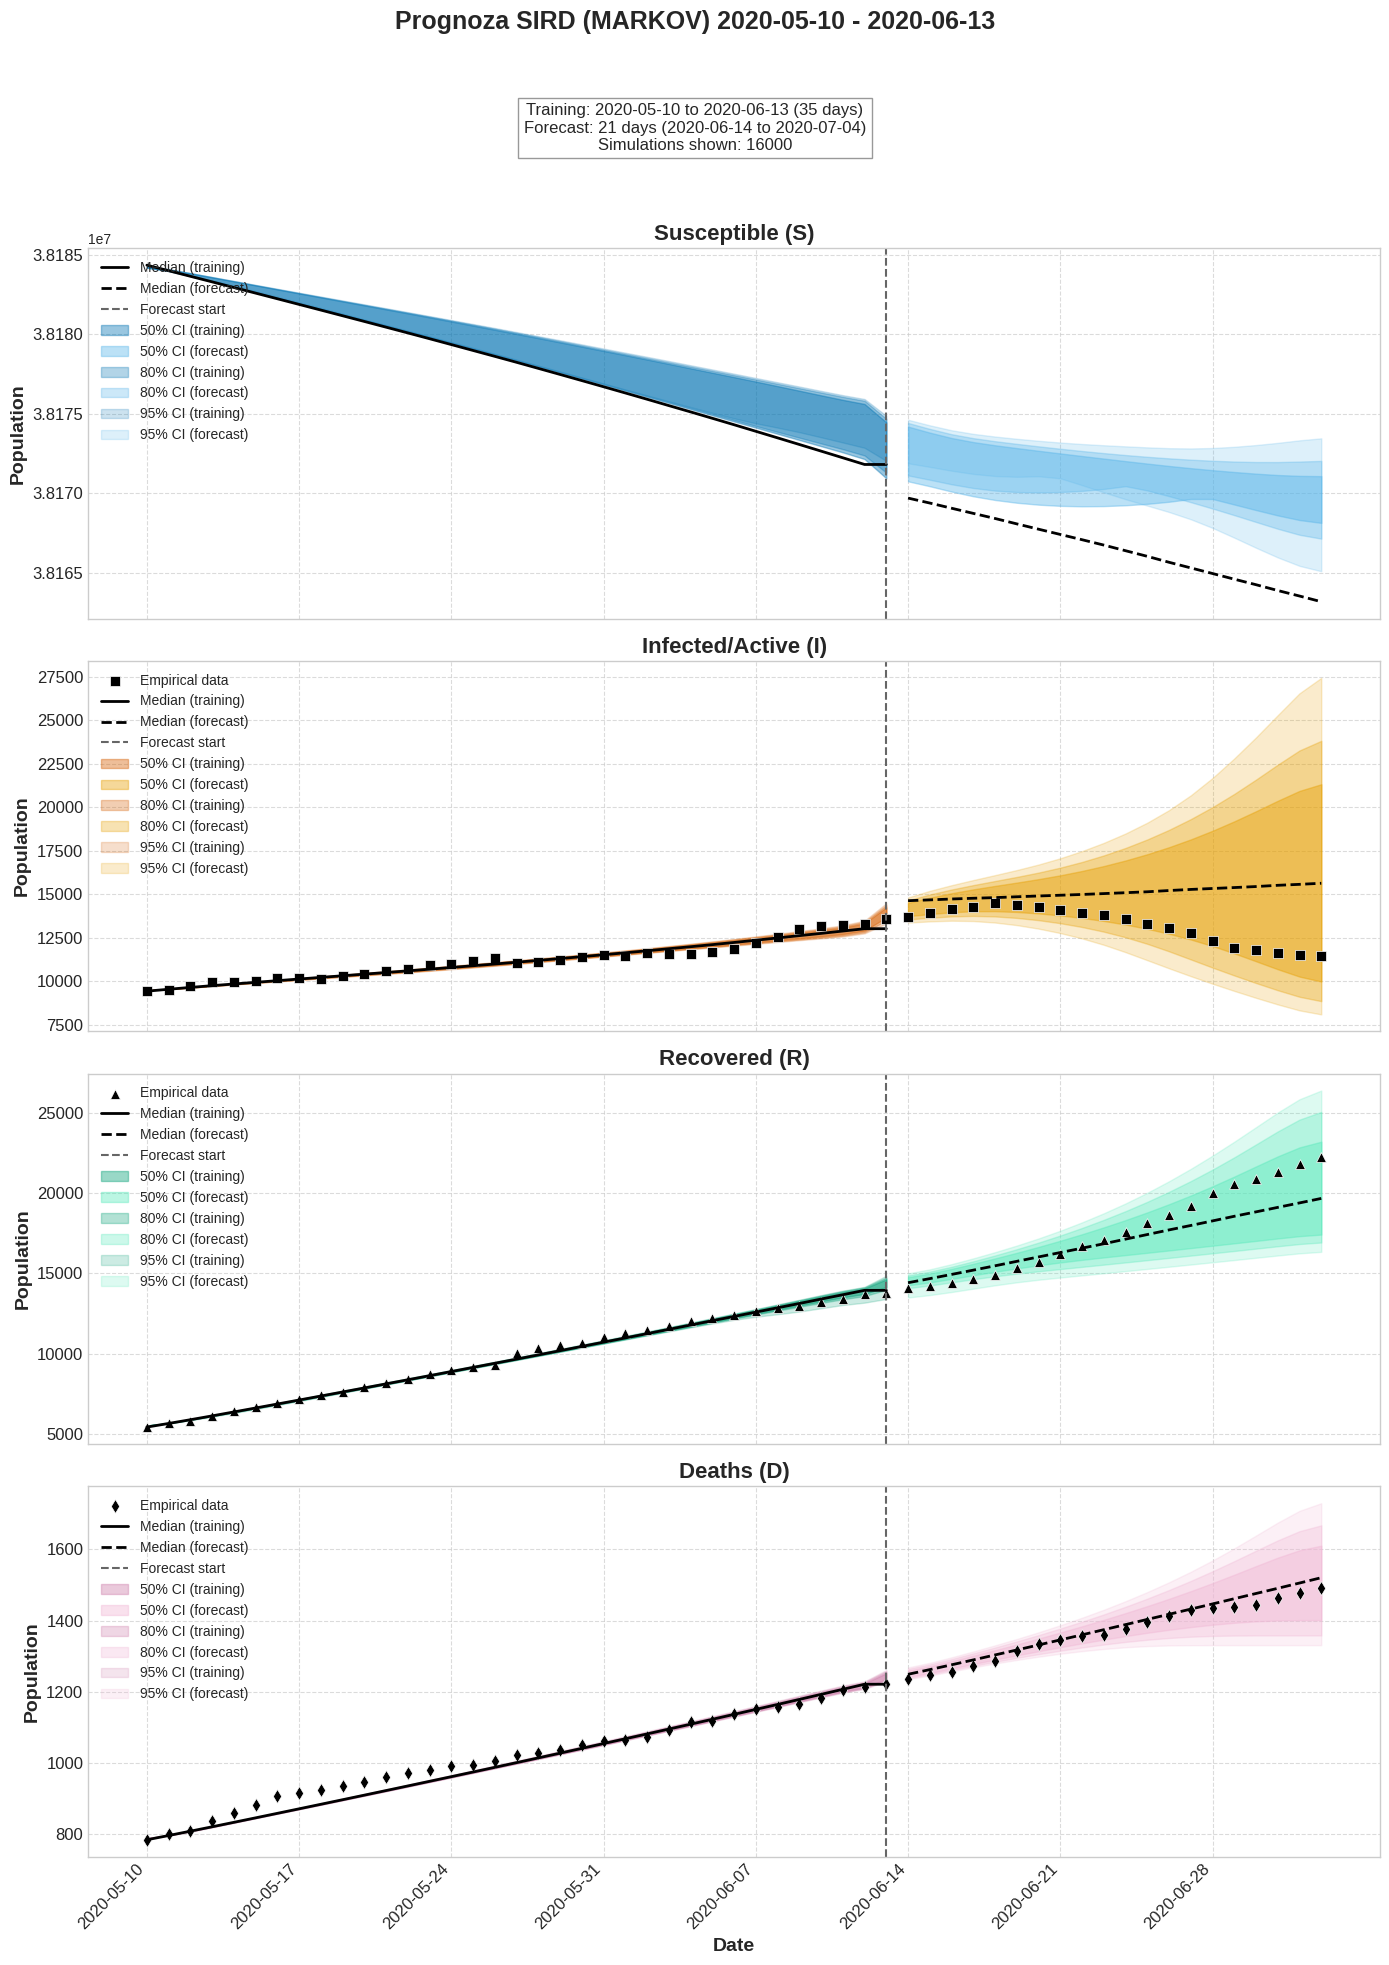

In [25]:
print("=== Ulepszony Model SIRD z Redukcją Residuów ===")
df = load_covid_data("/kaggle/input/polish-cov19-dataset/preprocessed_Poland.csv")
start_date = pd.to_datetime("2020-05-10")
end_date = pd.to_datetime("2020-06-13")
forecast_days = 21
output_dir = f"sird_analysis_{datetime.now().strftime('%Y%m%d_%H%M')}"
residual_method_choice = "markov"

print(f"\nParametry analizy:")
print(f"- Okres treningowy: {start_date.date()} do {end_date.date()}")
print(f"- Dni prognozy: {forecast_days}")
print(f"- Metoda residuów: {residual_method_choice}")
print(f"- Katalog wyjściowy: {output_dir}")

results = run_sird_with_advanced_residuals(
         df=df, start_date=start_date, end_date=end_date, forecast_days=forecast_days,
         residual_method=residual_method_choice, output_dir=output_dir, n_bootstrap=10
     )

if results:
    print(f"\nAnaliza zakończona pomyślnie. Wyniki zapisano w katalogu: {output_dir}")
else:
    print("\nAnaliza zakończona z błędami.")